# Fingerprint-based similarity scores

## Challenge
1. Many different fingerprints AND possible variations thereof (e.g. count/binary, log, weighted...) AND different metrics lead to **a lot** of possible variations!
2. No ground truth, so it is hard to measure what is good and what is better...

Data:

Compare multiple fingerprints on the "ms2 structures" dataset [Bushuiev 2024].

In [1]:
import os
import sys
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [2]:
filename = "compounds_unique_inchikey14.pickle"
compounds = pd.read_pickle(os.path.join(path_data, filename))
compounds.head()

,inchikey,inchi,smiles,spectrum_id
0,AAAQFGUYHFJNHI,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2c(ccc(OC)c2...,None
1,AABFWJDLCCDJJN,InChI=1S/C22H16N2O/c1-25-15-9-10-20-19(13-15)1...,COc1cc2c(cc1)[nH]c1c2ccnc1-c1cccc2ccccc12,None
2,AABILZKQMVKFHP,InChI=1S/C21H33NO8/c1-7-13(2)18(23)30-16-9-11-...,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,MSBNK-NaToxAq-NA003250
3,AABUHSBGEIUSRJ,InChI=1S/C17H16N2O2/c1-13(20)18-15-8-10-16(11-...,CC(O)=Nc1ccc(NC(=O)C=Cc2ccccc2)cc1,CCMSLIB00010107357
4,AABUKWVVUWBZCS,InChI=1S/C21H14O3/c22-16-11-12-17-18(13-16)24-...,O=c1oc2cc(O)ccc2c(-c2ccccc2)c1-c1ccccc1,CCMSLIB00010104862


In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

def calculate_mass(smiles):
    # Convert SMILES string to a molecule object
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return "Invalid SMILES"
    # Calculate the molecular mass
    mass = Descriptors.MolWt(molecule)
    return mass

In [4]:
masses = []
for smiles_string in tqdm(compounds.smiles):
    masses.append(calculate_mass(smiles_string))

  0%|          | 0/37663 [00:00<?, ?it/s]

In [5]:
compounds["mass"] = masses
compounds.head()

,inchikey,inchi,smiles,spectrum_id,mass
0,AAAQFGUYHFJNHI,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2c(ccc(OC)c2...,None,423.904
1,AABFWJDLCCDJJN,InChI=1S/C22H16N2O/c1-25-15-9-10-20-19(13-15)1...,COc1cc2c(cc1)[nH]c1c2ccnc1-c1cccc2ccccc12,None,324.383
2,AABILZKQMVKFHP,InChI=1S/C21H33NO8/c1-7-13(2)18(23)30-16-9-11-...,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,MSBNK-NaToxAq-NA003250,427.494
3,AABUHSBGEIUSRJ,InChI=1S/C17H16N2O2/c1-13(20)18-15-8-10-16(11-...,CC(O)=Nc1ccc(NC(=O)C=Cc2ccccc2)cc1,CCMSLIB00010107357,280.327
4,AABUKWVVUWBZCS,InChI=1S/C21H14O3/c22-16-11-12-17-18(13-16)24-...,O=c1oc2cc(O)ccc2c(-c2ccccc2)c1-c1ccccc1,CCMSLIB00010104862,314.340


In [9]:
# Add source code path
sys.path.insert(0, os.path.join(ROOT, "src"))

# Import funtion/classes from source code
from fingerprint_computation import FingerprintGenerator

In [7]:
import metrics


def compute_ruzicka_similarities(fingerprints):
    return metrics.ruzicka_similarity_matrix(fingerprints, fingerprints)

def compute_ruzicka_similarities_weighted(fingerprints, weights):
    return metrics.ruzicka_similarity_matrix_weighted(fingerprints, fingerprints, weights)

def compute_ruzicka_similarities_log(fingerprints):
    return metrics.ruzicka_similarity_matrix(np.log(1 + fingerprints), np.log(1 + fingerprints))

def compute_jaccard_similarities(fingerprints):
    return metrics.jaccard_similarity_matrix(fingerprints, fingerprints)

def compute_jaccard_similarities_weighted(fingerprints, weights):
    return metrics.jaccard_similarity_matrix_weighted(fingerprints, fingerprints, weights)

In [9]:
from rdkit.Chem import rdFingerprintGenerator


fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096)

fingerprints_rdkit = compute_fingerprints(
    compounds, fpgen, count=False, sparse=False
)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [10]:
compounds.shape[0]

37663

In [14]:
%%time

similarities_rdkit = compute_jaccard_similarities(fingerprints_rdkit)

CPU times: user 3min 55s, sys: 1min 18s, total: 5min 13s
Wall time: 15.2 s


In [15]:
similarities_rdkit.shape

(37663, 37663)

In [23]:
similarities_rdkit[:5, :5]

array([[1.        , 0.16414265, 0.22535211, 0.09383833, 0.1648299 ],
       [0.16414265, 1.        , 0.14056017, 0.07103825, 0.20114942],
       [0.22535211, 0.14056017, 1.        , 0.07820197, 0.14409369],
       [0.09383833, 0.07103825, 0.07820197, 1.        , 0.07368421],
       [0.1648299 , 0.20114942, 0.14409369, 0.07368421, 1.        ]],
      dtype=float32)

In [25]:
# similarities_rdkit = similarities_rdkit.astype(np.float16)

In [18]:
# too big! --> 5 GB !!
np.save("similarities_tanimoto_rdkit_4096bits.npy", similarities_rdkit)

In [9]:
similarities_rdkit = np.load("similarities_tanimoto_rdkit_4096bits.npy")

In [ ]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)
fingerprints_morgan3_count = compute_fingerprints(fpgen, True)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [16]:
%%time

similarities_morgan3_count = compute_ruzicka_similarities(fingerprints_morgan3_count)

CPU times: user 1h 13min 32s, sys: 7.83 s, total: 1h 13min 40s
Wall time: 2min 33s


In [19]:
# too big! --> 5 GB !!
np.save("similarities_ruzicka_morgan3_4096bits.npy", similarities_morgan3_count)

In [9]:
similarities_morgan3_count = np.load("similarities_ruzicka_morgan3_4096bits.npy")

In [26]:
# similarities_morgan3_count = similarities_morgan3_count.astype(np.float16)

In [17]:
similarities_morgan3_count.shape

(37663, 37663)

## Morgan-3 binary + Tanimoto

In [61]:
fingerprints_morgan3 = compute_fingerprints(fpgen, count=False)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [62]:
%%time

similarities_morgan3 = compute_jaccard_similarities(fingerprints_morgan3)

CPU times: user 4min 18s, sys: 1min 18s, total: 5min 37s
Wall time: 15.8 s


In [63]:
# too big! --> 5 GB !!
np.save("similarities_tanimoto_morgan3_4096bits.npy", similarities_morgan3)

In [11]:
similarities_morgan3 = np.load("similarities_tanimoto_morgan3_4096bits.npy")

## Morgan-2 count

In [22]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096)

#fingerprints_morgan2_count = compute_fingerprints(fpgen, count=True)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [23]:
%%time

#similarities_morgan2_count = compute_ruzicka_similarities(fingerprints_morgan2_count)

CPU times: user 1h 9min 20s, sys: 7.33 s, total: 1h 9min 27s
Wall time: 2min 27s


## Morgan-6 count

In [65]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096)

fingerprints_morgan6_count = compute_fingerprints(fpgen, count=True)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [66]:
%%time

similarities_morgan6_count = compute_ruzicka_similarities(fingerprints_morgan6_count)

CPU times: user 1h 8min 57s, sys: 8.09 s, total: 1h 9min 5s
Wall time: 2min 28s


In [69]:
# too big! --> 5 GB !!
np.save("similarities_ruzicka_morgan6_4096bits.npy", similarities_morgan6_count)

## Morgan-9 count

In [67]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096)

fingerprints_morgan9_count = compute_fingerprints(fpgen, count=True)

  0%|          | 0/37663 [00:00<?, ?it/s]

In [68]:
%%time

similarities_morgan9_count = compute_ruzicka_similarities(fingerprints_morgan9_count)

CPU times: user 1h 9min 36s, sys: 8.68 s, total: 1h 9min 45s
Wall time: 2min 28s


In [70]:
# too big! --> 5 GB !!
np.save("similarities_ruzicka_morgan9_4096bits.npy", similarities_morgan9_count)

In [28]:
similarities_morgan9_count = np.load("similarities_ruzicka_morgan9_4096bits.npy")

## MAP4

In [30]:
from typing import List
from rdkit.Chem import Mol, MolFromSmiles # pylint: disable=import-error,no-name-in-module
from map4 import MAP4


map4 = MAP4(
    dimensions=4096,
    radius=2,
    include_duplicated_shingles=True,
)

mol = MolFromSmiles(compounds.smiles[4])

fp_map4 = map4._calculate(mol)
len(fp_map4)

552

In [31]:
map4 = MAP4(
    dimensions=4096,
    radius=2,
    include_duplicated_shingles=False,
)

mol = MolFromSmiles(compounds.smiles[4])

fp_map4 = map4._calculate(mol)
len(fp_map4)

268

In [29]:
fp_map4

{b'O=c(c)o|1|c(=O)(oc)c(c)-c|1',
 b'O=c(c)o|2|c(-c(c)c)(c(c)-c)c(=O)o|1',
 b'O=c(c)o|2|o(c(c)=O)c(c)c|1',
 b'O=c(c)o|3|c(-c(c)c)(c(c)-c)c(c)c|1',
 b'O=c(c)o|3|c(cc)(cc)-c(c)c|1',
 b'O=c(c)o|3|c(cc)(oc)c(c)c|1',
 b'O=c(c)o|4|c(c(c)O)c(c)o|1',
 b'O=c(c)o|4|c(cc)(c(c)-c)c(c)o|1',
 b'O=c(c)o|4|c(cc)(cc)-c(c)c|1',
 b'O=c(c)o|4|c(cc)c(c)-c|1',
 b'O=c(c)o|4|c(cc)c(c)-c|2',
 b'O=c(c)o|5|c(O)(cc)cc|1',
 b'O=c(c)o|5|c(cc)c(c)-c|1',
 b'O=c(c)o|5|c(cc)c(c)-c|2',
 b'O=c(c)o|5|c(cc)c(c)c|1',
 b'O=c(c)o|5|c(cc)cc|1',
 b'O=c(c)o|5|c(cc)cc|2',
 b'O=c(c)o|6|c(cc)c(c)O|1',
 b'O=c(c)o|6|c(cc)cc|1',
 b'O=c(c)o|6|c(cc)cc|2',
 b'O=c(c)o|6|c(cc)cc|3',
 b'O=c(c)o|7|c(cc)cc|1',
 b'O=c|1|c(c)(=O)o|1',
 b'O=c|2|c(c)(c)-c|1',
 b'O=c|2|o(c)c|1',
 b'O=c|3|c(c)(c)-c|1',
 b'O=c|3|c(c)(c)-c|2',
 b'O=c|3|c(c)(c)o|1',
 b'O=c|4|c(c)(c)-c|1',
 b'O=c|4|c(c)(c)c|1',
 b'O=c|4|c(c)c|1',
 b'O=c|4|c(c)c|2',
 b'O=c|4|c(c)c|3',
 b'O=c|5|c(c)(c)O|1',
 b'O=c|5|c(c)c|1',
 b'O=c|5|c(c)c|2',
 b'O=c|5|c(c)c|3',
 b'O=c|5|c(c)c|4',
 b'O=c

In [71]:
mol = MolFromSmiles("C[C@H](N)C(=O)O")
fp_map4 = map4._calculate(mol)              
fp_map4

{b'C(C)(C)N|1|C([CH])(=O)O',
 b'C(C)(N)C(=O)O|1|C(=O)(O)C(C)N',
 b'CC(C)N|1|C(C)(N)C(=O)O',
 b'CC(C)N|2|C(=O)(O)C(C)N',
 b'CC(C)N|2|NC(C)C',
 b'CC(C)N|3|O=C([CH])O',
 b'CC(C)N|3|OC([CH])=O',
 b'C[CH]|1|C(C)(C)N',
 b'C[CH]|2|C([CH])(=O)O',
 b'C[CH]|2|N[CH]',
 b'NC(C)C|1|C(C)(N)C(=O)O',
 b'NC(C)C|2|C(=O)(O)C(C)N',
 b'NC(C)C|3|O=C([CH])O',
 b'NC(C)C|3|OC([CH])=O',
 b'N[CH]|1|C(C)(C)N',
 b'N[CH]|2|C([CH])(=O)O',
 b'O=C([CH])O|1|C(=O)(O)C(C)N',
 b'O=C([CH])O|2|C(C)(N)C(=O)O',
 b'O=C([CH])O|2|OC([CH])=O',
 b'O=C|1|C([CH])(=O)O',
 b'O=C|2|C(C)(C)N',
 b'O=C|3|C[CH]',
 b'O=C|3|N[CH]',
 b'OC([CH])=O|1|C(=O)(O)C(C)N',
 b'OC([CH])=O|2|C(C)(N)C(=O)O',
 b'OC|1|C([CH])(=O)O',
 b'OC|2|C(C)(C)N',
 b'OC|2|O=C',
 b'OC|3|C[CH]',
 b'OC|3|N[CH]'}

In [38]:
#map4.visualize([MolFromSmiles(smiles) for smiles in tqdm(compounds.smiles.values[:100])], compounds.mass.values[:100])

In [72]:
map4.encoder.hash(fp_map4)

array([1953498882, 3262159556,  934068227, 1281964487, 3372583446,
       3791407854, 2798229975, 2824574546, 2453060671, 1318181370,
       2049971091,  131540014,  932829630,  517185771, 1196336097,
       3256987466, 2308592037, 1119303752, 2590113096, 3033657598,
        688484640, 3100332022, 3493139589,  106099204, 4029924615,
       1697855386, 3456481013,  523852024, 2991247268, 2531531010])

In [79]:
smiles_large = compounds.sort_values("mass", ascending=False).smiles.values[:3]

map4 = MAP4(
    dimensions=40000,
    radius=2,
    include_duplicated_shingles=False,
)

mol = MolFromSmiles(smiles_large[0])
fp_1 = map4._calculate(mol)
fp_1_vector = map4._fold(fp_1)

mol = MolFromSmiles(smiles_large[1])
fp_2 = map4._calculate(mol)
fp_2_vector = map4._fold(fp_2)

mol = MolFromSmiles(smiles_large[2])
fp_3 = map4._calculate(mol)
fp_3_vector = map4._fold(fp_3)

In [80]:
len(fp_1), len(fp_2), len(fp_3)

(20317, 24183, 24124)

In [81]:
len(set(map4.encoder.hash(fp_1)))

20317

In [82]:
fp_1_vector.sum()

np.uint64(15925)

In [87]:
map4.encoder.distance(fp_1, fp_2), map4.encoder.distance(fp_1, fp_1)

(1.0, 0.9999507801348624)

In [93]:
map4.encoder.distance(set(map4.encoder.hash(fp_1)), set(map4.encoder.hash(fp_1)))

0.9999507801348624

In [ ]:
map4.encoder.distance

In [84]:
1 - map4.encoder.distance(fp_1_vector, fp_2_vector)

0.5158

In [85]:
map4.encoder.distance(fp_1_vector, fp_1_vector)

0.0

In [86]:
from metrics import jaccard_similarity_matrix

jaccard_similarity_matrix([fp_1_vector, fp_2_vector, fp_3_vector], [fp_1_vector, fp_2_vector, fp_3_vector])

array([[1.        , 0.2758814 , 0.2747903 ],
       [0.2758814 , 1.        , 0.82246083],
       [0.2747903 , 0.82246083, 1.        ]], dtype=float32)

In [56]:
fp_1_vector = map4._fold(fp_1)
fp_1_vector.shape

(4096,)

In [57]:
fp_1_vector.sum()

np.uint64(4066)

In [42]:
map4.encoder.distance(fp_map4, fp_map4)

0.996268656716418

In [21]:
def get_num_bits(smiles):
    mol = MolFromSmiles(smiles)
    return len(map4._calculate(mol))

num_bits = np.array([get_num_bits(s) for s in tqdm(compounds.smiles)])

  0%|          | 0/37663 [00:00<?, ?it/s]

(array([2.1891e+04, 1.0581e+04, 2.7910e+03, 1.3030e+03, 4.4300e+02,
        2.5000e+02, 1.2800e+02, 7.8000e+01, 6.3000e+01, 4.4000e+01,
        2.1000e+01, 2.0000e+01, 1.4000e+01, 1.2000e+01, 1.0000e+01,
        2.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([2.0000000e+00, 6.0652500e+02, 1.2110500e+03, 1.8155750e+03,
        2.4201000e+03, 3.0246250e+03, 3.6291500e+03, 4.2336750e+03,
        4.8382000e+03, 5.4427250e+03, 6.0472500e+03, 6.6517750e+03,
        7.2563000e+03, 7.8608250e+03, 8.4653500e+03, 9.0698750e+03,
        9.6744000e+03, 1.0278925e+04, 1.0883450e+04, 1.1487975e+04,
        1.2092500e+04, 1.2697025e+04, 1.3301550e+04, 1.3906075e+04,
        1.4510600e+04, 1.5115125e+04, 1.571965

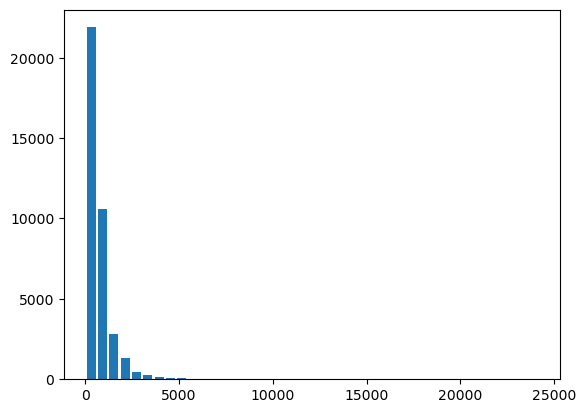

In [23]:
plt.hist(num_bits, bins=40, rwidth=0.8)
#plt.show()

In [15]:
len(fp_map4)

700

In [97]:
2048*2**4

32768

In [98]:
map4 = MAP4(
    dimensions=4096,
    radius=2,
    include_duplicated_shingles=False,
)

In [99]:
molecules: List[Mol] = [MolFromSmiles(smiles) for smiles in tqdm(compounds.smiles.values)]
fingerprints_map4: np.ndarray = map4.calculate_many(
    molecules,
    number_of_threads=32,
    verbose=True,
)

  0%|          | 0/37663 [00:00<?, ?it/s]

Calculating fingerprints:   0%|                       | 0/37663 [00:00<?, ?it/s]

In [100]:
fingerprints_map4.shape

(37663, 4096)

In [101]:
%%time

similarities_map4 = compute_jaccard_similarities(fingerprints_map4)

CPU times: user 3min 38s, sys: 1min 15s, total: 4min 53s
Wall time: 14.2 s


## Compare score distributions

Things to consider:
- remove the diagonal (to not count the pairs of compounds with themselves)
- different scores will scale very differently -- adjust scale/align between all scores!

In [9]:
#from utils import remove_diagonal

def remove_diagonal(A):
    m = A.shape[0]
    strided = np.lib.stride_tricks.as_strided
    s0,s1 = A.strides
    return strided(A.ravel()[1:], shape=(m-1,m), strides=(s0+s1,s1)).reshape(m,-1)



def compare_distributions(
    similarities1,
    similarities2,
    label1,
    label2,
    title="",
    ignore_diagonal=True
):
    if ignore_diagonal:
        similarities1 = remove_diagonal(similarities1)
        similarities2 = remove_diagonal(similarities2)

    fig, ax = plt.subplots(1, figsize=(8, 5))
    ax.hist(similarities1.reshape(-1),
                    bins=50, rwidth=0.8, alpha=0.5, label=label1)
    ax.hist(similarities2.reshape(-1),
                    bins=50, rwidth=0.8, alpha=0.5, label=label2)
    ax.set_title(title)
    ax.set_xlabel("Tanimoto(-like) score")
    ax.set_ylabel("Score counts")
    
    ax.set_yscale("log")
    ax.set_yscale("log")
    plt.legend()
    plt.show()

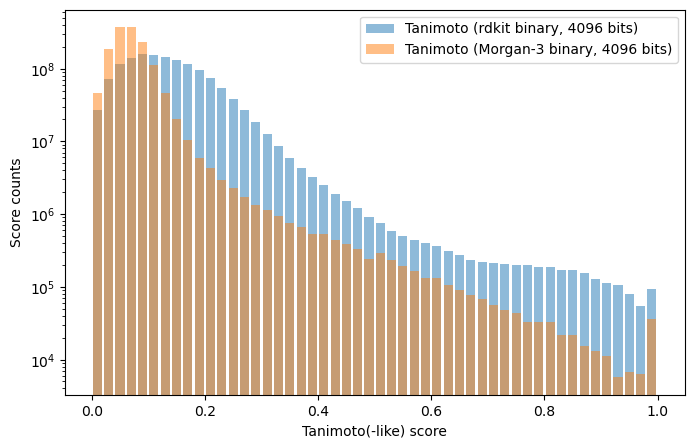

In [13]:
NBITS = 4096

compare_distributions(
    similarities_rdkit,
    similarities_morgan3,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    ignore_diagonal=True,
)

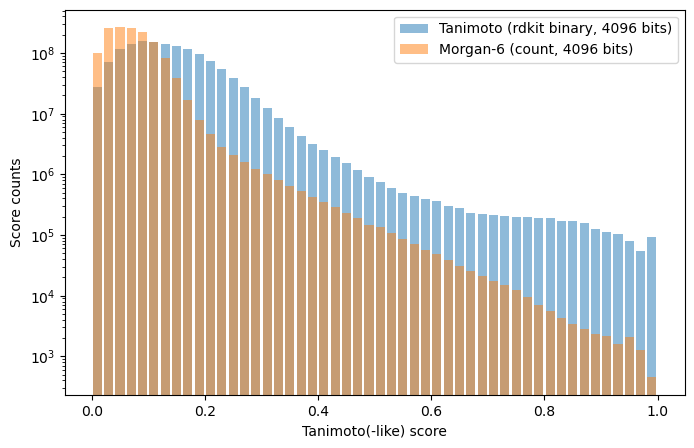

In [29]:
NBITS = 4096

compare_distributions(similarities_rdkit,
                      similarities_count_morgan6,
                      f"Tanimoto (rdkit binary, {NBITS} bits)",
                      f"Morgan-6 (count, {NBITS} bits)",
)

In [17]:
100 * (similarities_morgan3_count > 0.8).sum() / similarities_rdkit.shape[0]**2

np.float64(0.008715182464489752)

In [16]:
100 * (similarities_rdkit > 0.8).sum() / similarities_rdkit.shape[0]**2

np.float64(0.09088442538056861)

## Compare score vs. score using heatmap

In [55]:
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt

def heatmap_comparison(similarities1, similarities2, label1, label2, bins=50,
                       colormap="viridis",
                       ignore_diagonal=True,
                       filename=None):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # Compute the 2D histogram
    if ignore_diagonal:
        iu1 = np.triu_indices(similarities1.shape[0], k=1)
    else:
        iu1 = np.triu_indices(similarities1.shape[0], k=0)

    hist, x_edges, y_edges = np.histogram2d(
        similarities1[iu1], 
        similarities2[iu1], 
        bins=bins
    )
    
    # Display the heatmap using imshow with logarithmic color scale
    im = ax.imshow(hist.T, origin='lower', aspect='equal',
                   extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                   cmap=colormap, norm=LogNorm(vmin=1, vmax=np.max(hist)))
    
    # Add colorbar with proper tick formatting
    cb = fig.colorbar(im, ax=ax)
    cb.set_label('Count')

    total_sum = iu1[0].shape[0]

    # Add text annotations for each 5x5 square
    step = bins // 5
    for i in range(0, bins, step):
        for j in range(0, bins, step):
            # Compute the sum of the elements in the 5x5 square
            sub_matrix = hist[i:i+step, j:j+step]
            subsection_sum = np.sum(sub_matrix)
            
            # Compute the center of the square for placing the text
            x_center = (x_edges[i] + x_edges[i + step]) / 2
            y_center = (y_edges[j] + y_edges[j + step]) / 2
            
            # Add the text to the plot
            if subsection_sum > 0:
                ax.text(x_center, y_center, f"{(100 * subsection_sum / total_sum):.2f}%", color="white", 
                        ha="center", va="center", fontsize=6, zorder=2)
    
    # Add grid and labels
    ax.grid(True, zorder=1)
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

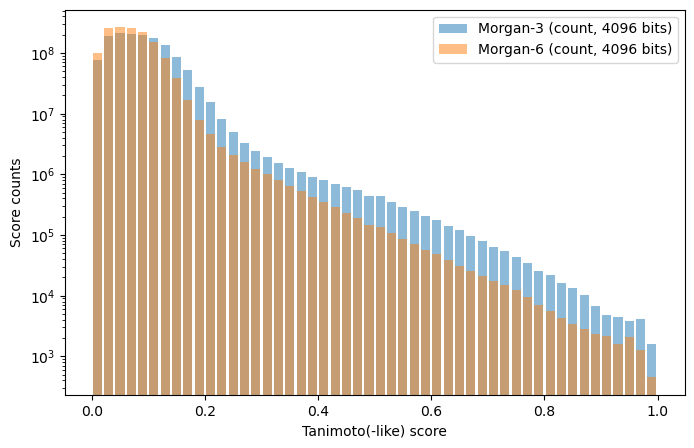

In [26]:
NBITS = 4096

compare_distributions(similarities_morgan3_count,
                      similarities_morgan6_count,
                      f"Morgan-3 (count, {NBITS} bits)",
                      f"Morgan-6 (count, {NBITS} bits)",
)

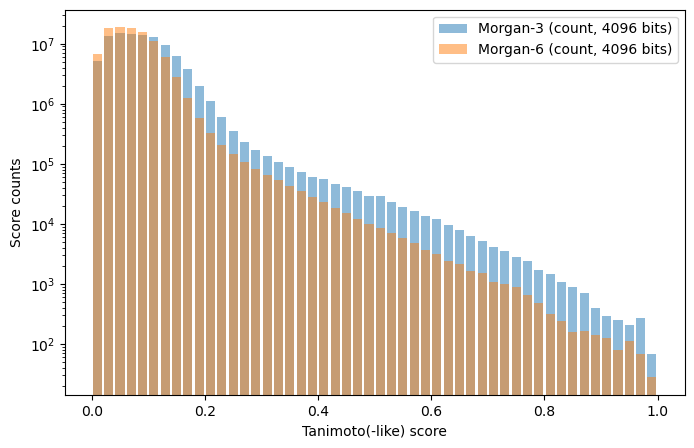

In [23]:
NBITS = 4096

compare_distributions(similarities_count_morgan3,
                      similarities_count_morgan6,
                      f"Morgan-3 (count, {NBITS} bits)",
                      f"Morgan-6 (count, {NBITS} bits)",
)

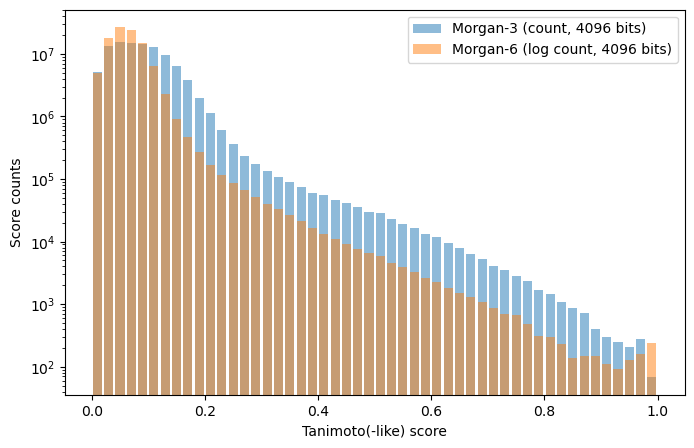

In [83]:
NBITS = 4096

compare_distributions(similarities_count_morgan3,
                      similarities_count_morgan6_log,
                      f"Morgan-3 (count, {NBITS} bits)",
                      f"Morgan-6 (log count, {NBITS} bits)",
)

## Compare score distributions for small and larger molecules

8578 8525


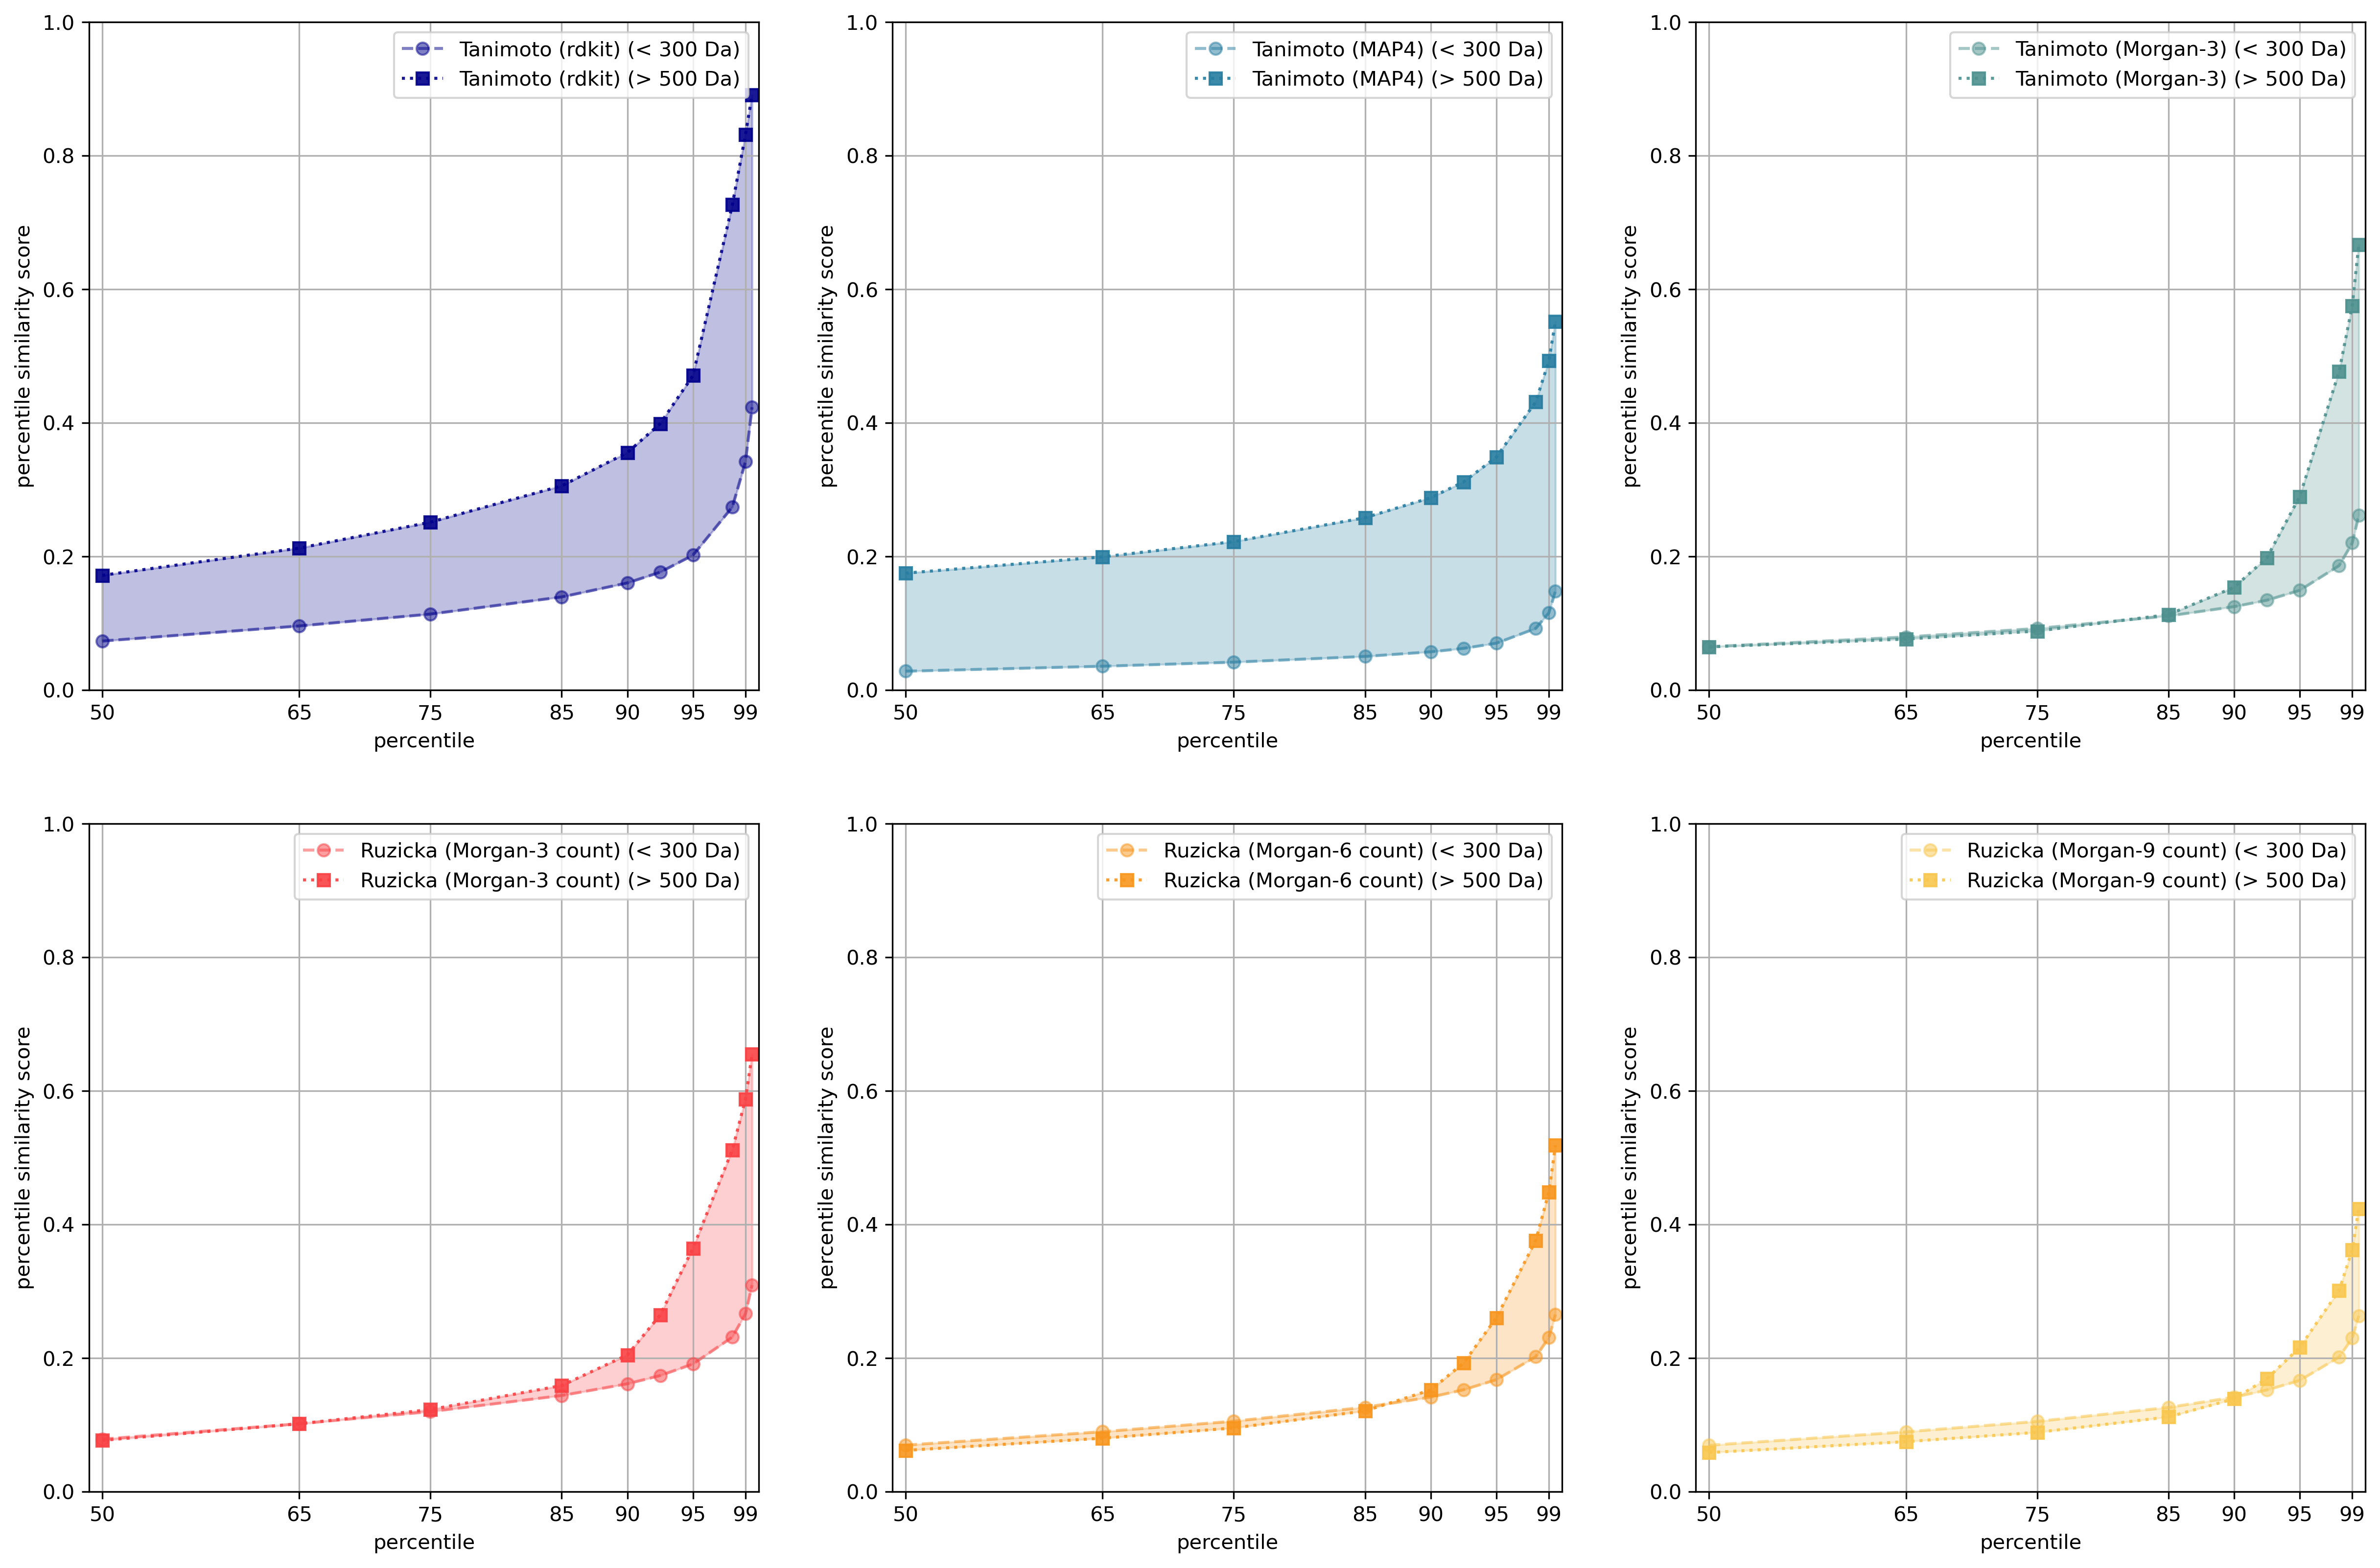

In [54]:
#percentiles = np.arange(0, 101)
percentiles = [50, 65, 75, 85, 90, 92.5, 95, 98, 99, 99.5] #, 99.9]
percentiles_ticks = [50, 65, 75, 85, 90, 95, 99]

mass_low = 300
mass_high = 500

idx1 = np.where(compounds.mass > mass_high)[0]
idx0 = np.where(compounds.mass < mass_low)[0]
print(idx0.shape[0], idx1.shape[0])

similarities_dict = {
    "Tanimoto (rdkit)": similarities_rdkit,
    "Tanimoto (MAP4)": similarities_map4,
    "Tanimoto (Morgan-3)": similarities_morgan3,
    #"Ruzicka (Morgan-2 count, 4096 bits)": similarities_morgan2_count,
    "Ruzicka (Morgan-3 count)": similarities_morgan3_count,
    "Ruzicka (Morgan-6 count)": similarities_morgan6_count,
    "Ruzicka (Morgan-9 count)": similarities_morgan9_count,
}

# Compare selected percentiles
fig, axes = plt.subplots(2, 3, figsize=(20, 13), dpi=300)


#colors = ["darkblue", "dodgerblue", "teal", "darkred", "crimson", "orange"]
colors = ["darkblue", "#277DA1", "#4D908E", "#F94144", "#F8961E", "#F9C74F"]

curves =  {key: {} for key, _ in similarities_dict.items()}

coords = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

for i, (key, similarities) in enumerate(similarities_dict.items()):
    percentile_scores = np.percentile(similarities[np.ix_(idx0, idx0)].reshape(-1), percentiles)
    curves[key][mass_low] = percentile_scores
    axes[coords[i]].plot(percentiles, percentile_scores, ".--", markersize=12, label=key+f" (< {mass_low} Da)", color=colors[i], alpha=0.5)

    percentile_scores = np.percentile(similarities[np.ix_(idx1, idx1)].reshape(-1), percentiles)
    curves[key][mass_high] = percentile_scores
    axes[coords[i]].plot(percentiles, percentile_scores, "s:", markersize=6, label=key+f" (> {mass_high} Da)", color=colors[i],  alpha=0.9)

for i, (key, similarities) in enumerate(similarities_dict.items()):
    axes[coords[i]].fill_between(percentiles, curves[key][mass_low], curves[key][mass_high], color=colors[i], alpha=0.25)

    axes[coords[i]].set_xticks(percentiles_ticks, [str(x) for x in percentiles_ticks])
    axes[coords[i]].grid(True)
    axes[coords[i]].set_xlabel("percentile")
    axes[coords[i]].set_ylabel("percentile similarity score")
    axes[coords[i]].set_ylim(0, 1)
    axes[coords[i]].set_xlim(49, 100)
    axes[coords[i]].legend()

plt.tight_layout()
plt.savefig("fig_low_high_mass_score_percentiles.pdf")
plt.savefig("fig_low_high_mass_score_percentiles.png", dpi=400)
plt.show()

# Score vs Score comparisons

This was previously done using hexbin plots, which look nice, but fail for too large data due to matplotlib caused memory inefficiency (required > 120GB RAM).

So now using heatmap plots.

## Tanimoto (rdkit) vs Tanimoto (Morgan-3)

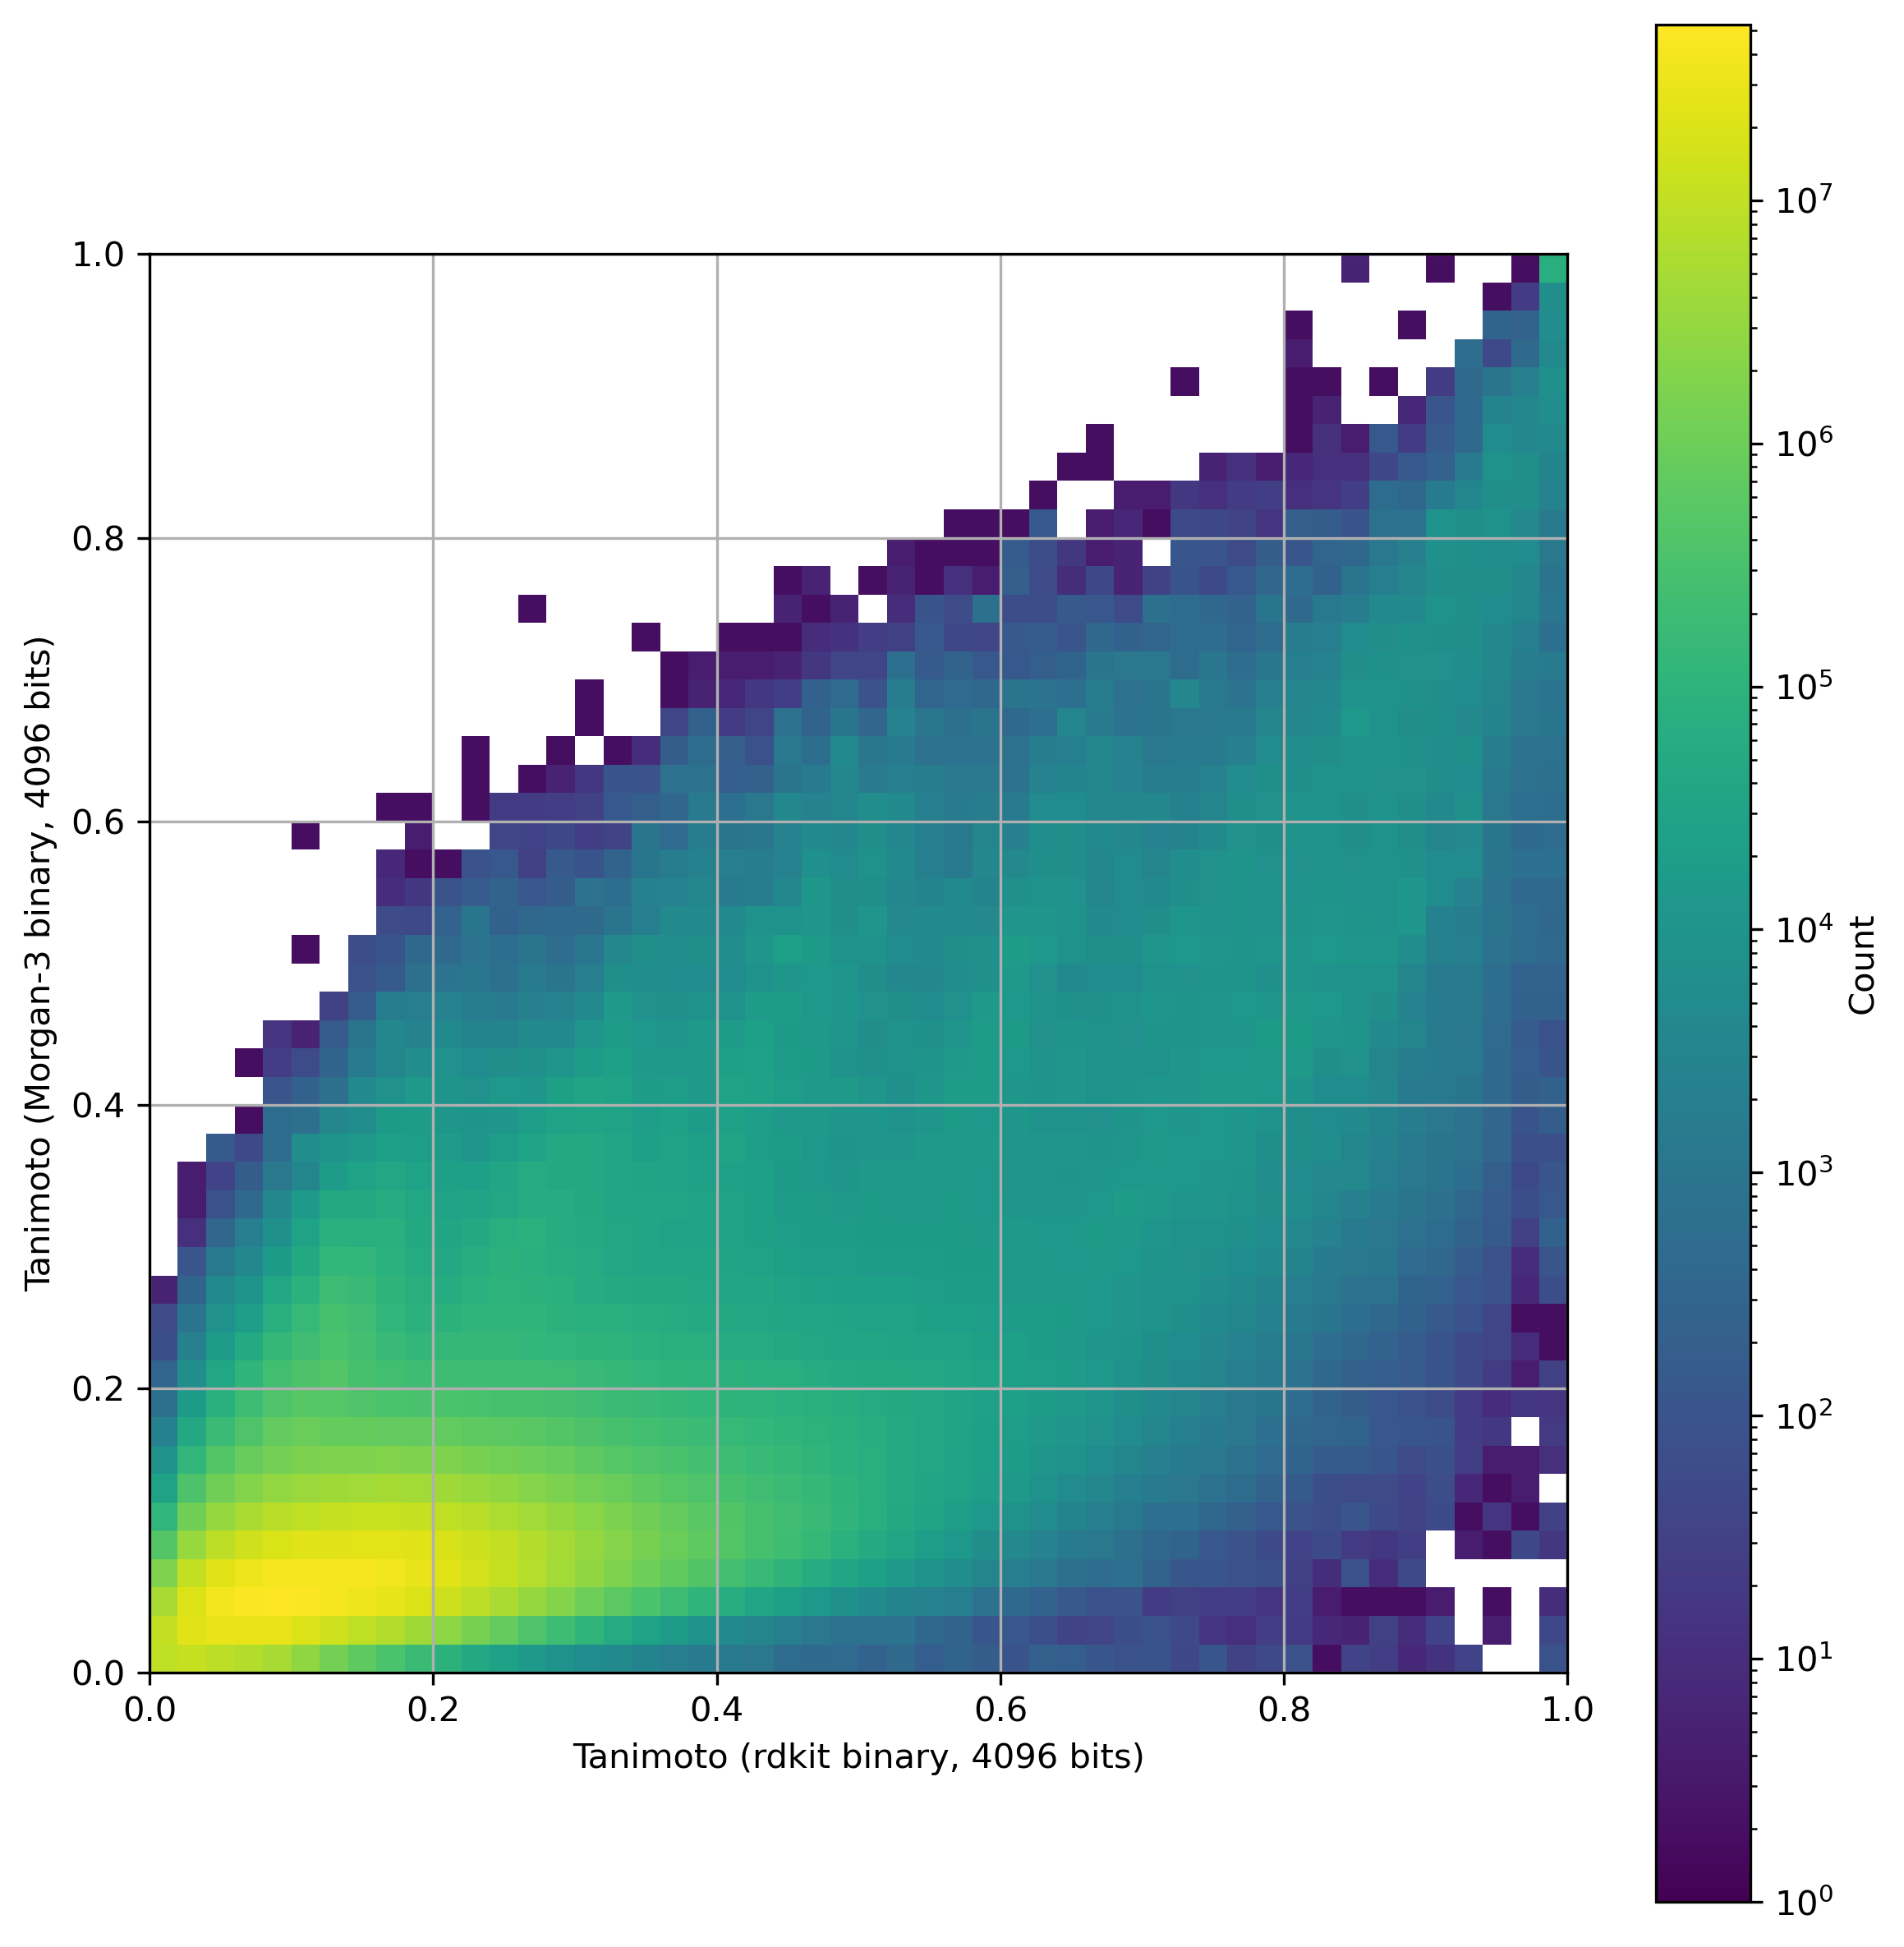

In [64]:
heatmap_comparison(
    similarities_rdkit,
    similarities_morgan3,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    bins=50,
    filename="heatmap_tanimoto_rdkit_vs_tanimoto_morgan3.png"
)

## Tanimoto (rdkit) vs Ruzicka (Morgan-3)

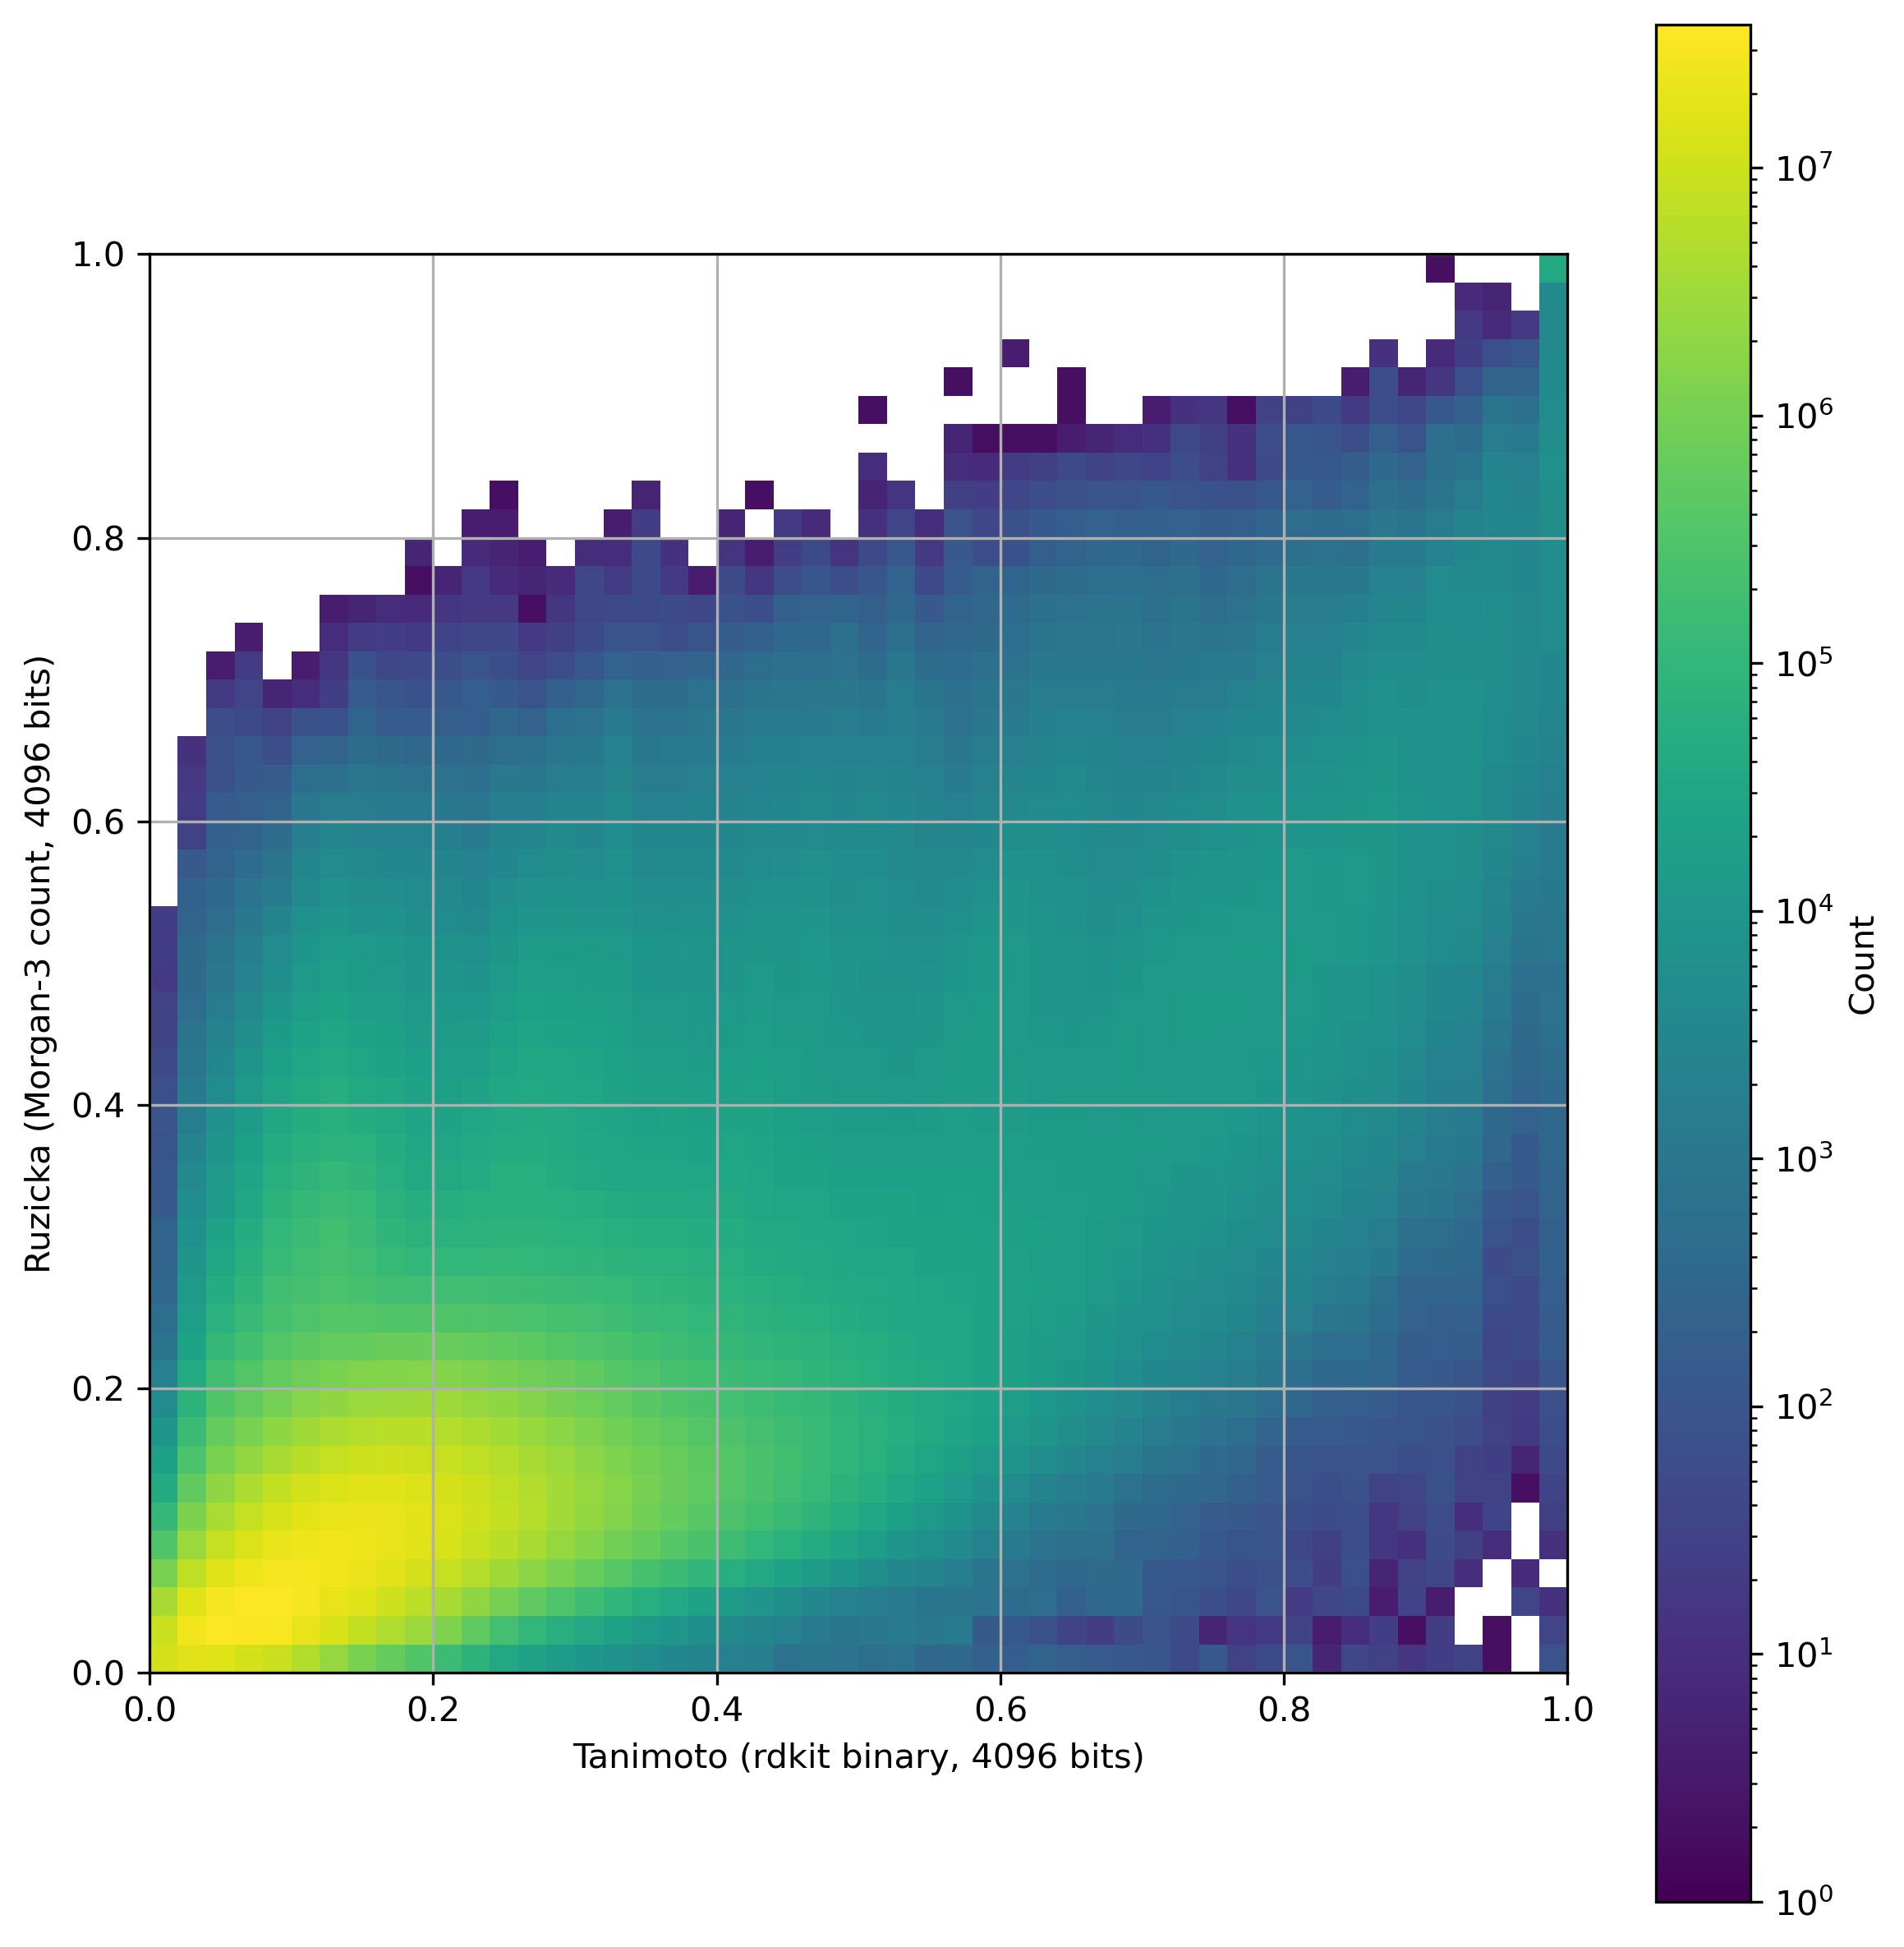

In [55]:
heatmap_comparison(
    similarities_rdkit,
    similarities_morgan3_count,
    f"Tanimoto (rdkit binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    bins=50,
    filename="heatmap_tanimoto_rdkit_vs_ruzicka_morgan3.png"
)

## Tanimoto (Morgan-3) vs Ruzicka (Morgan-3)

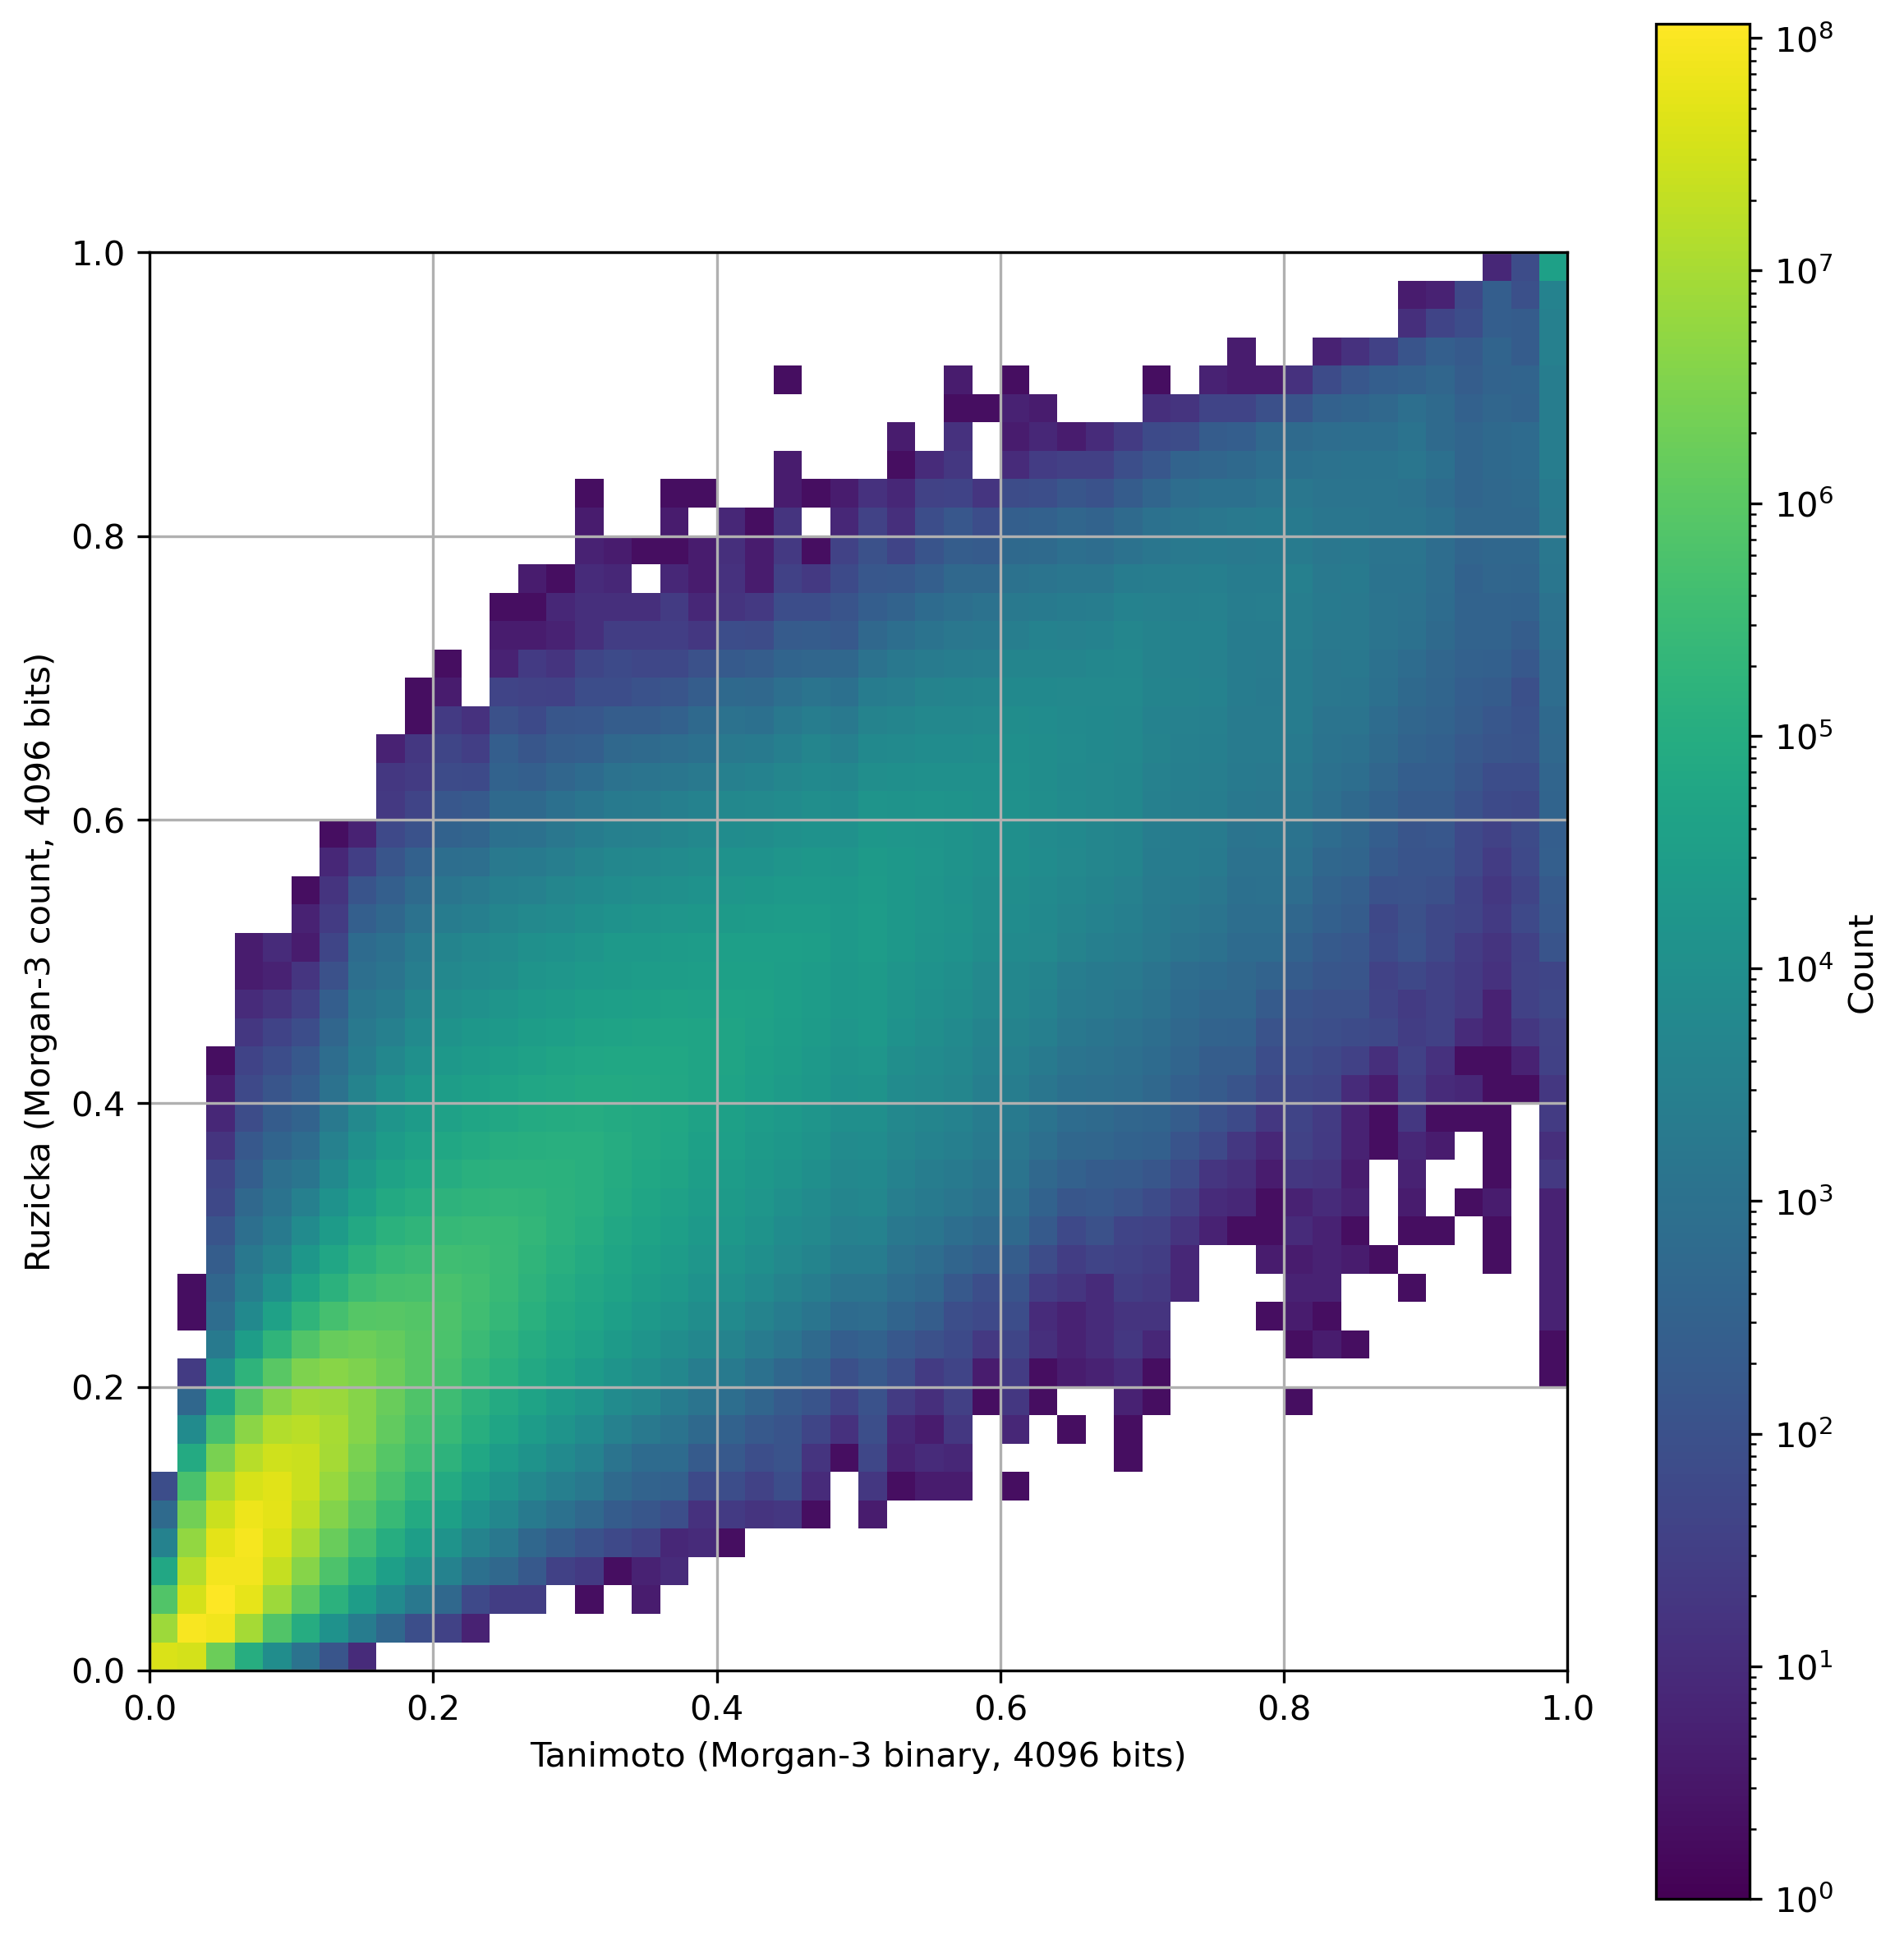

In [72]:
heatmap_comparison(
    similarities_morgan3,
    similarities_morgan3_count,
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    bins=50,
    filename="heatmap_tanimoto_morgan3_vs_ruzicka_morgan3.png"
)

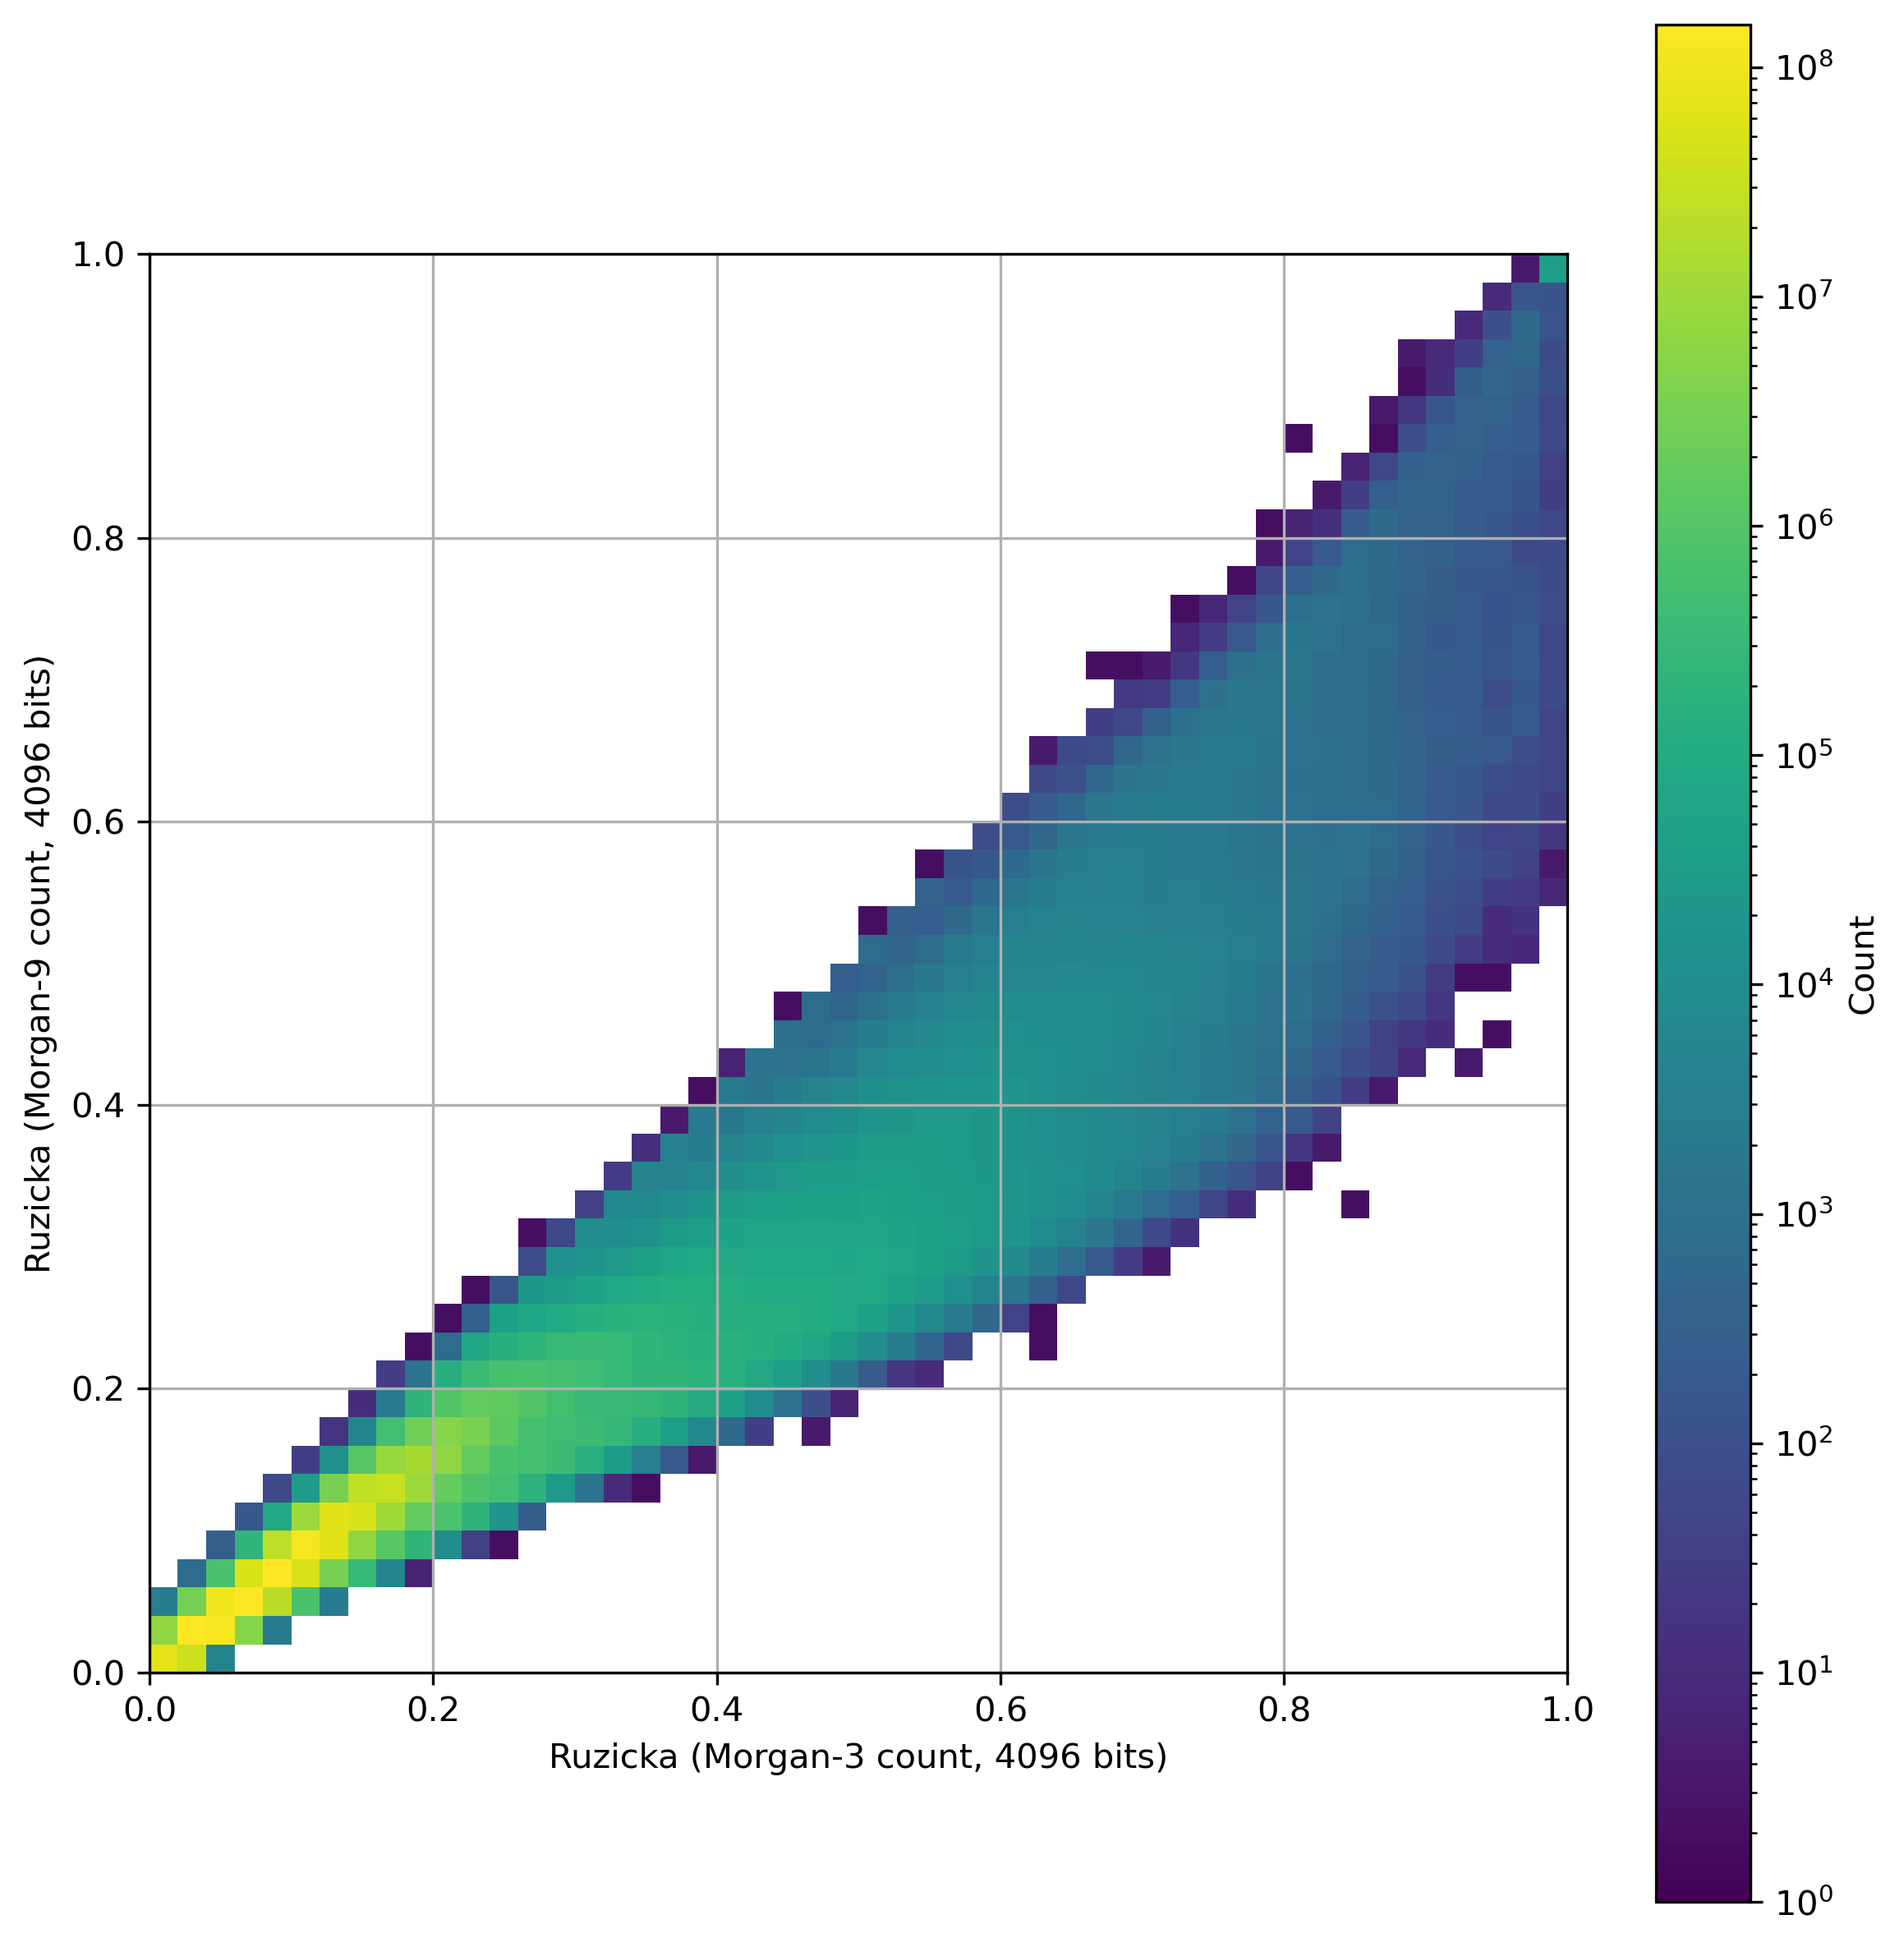

In [74]:
heatmap_comparison(
    similarities_morgan3_count,
    similarities_morgan9_count,
    f"Ruzicka (Morgan-3 count, {NBITS} bits)",
    f"Ruzicka (Morgan-9 count, {NBITS} bits)",
    bins=50,
    filename="heatmap_ruzicka_morgan3_vs_ruzicka_morgan9.png"
)

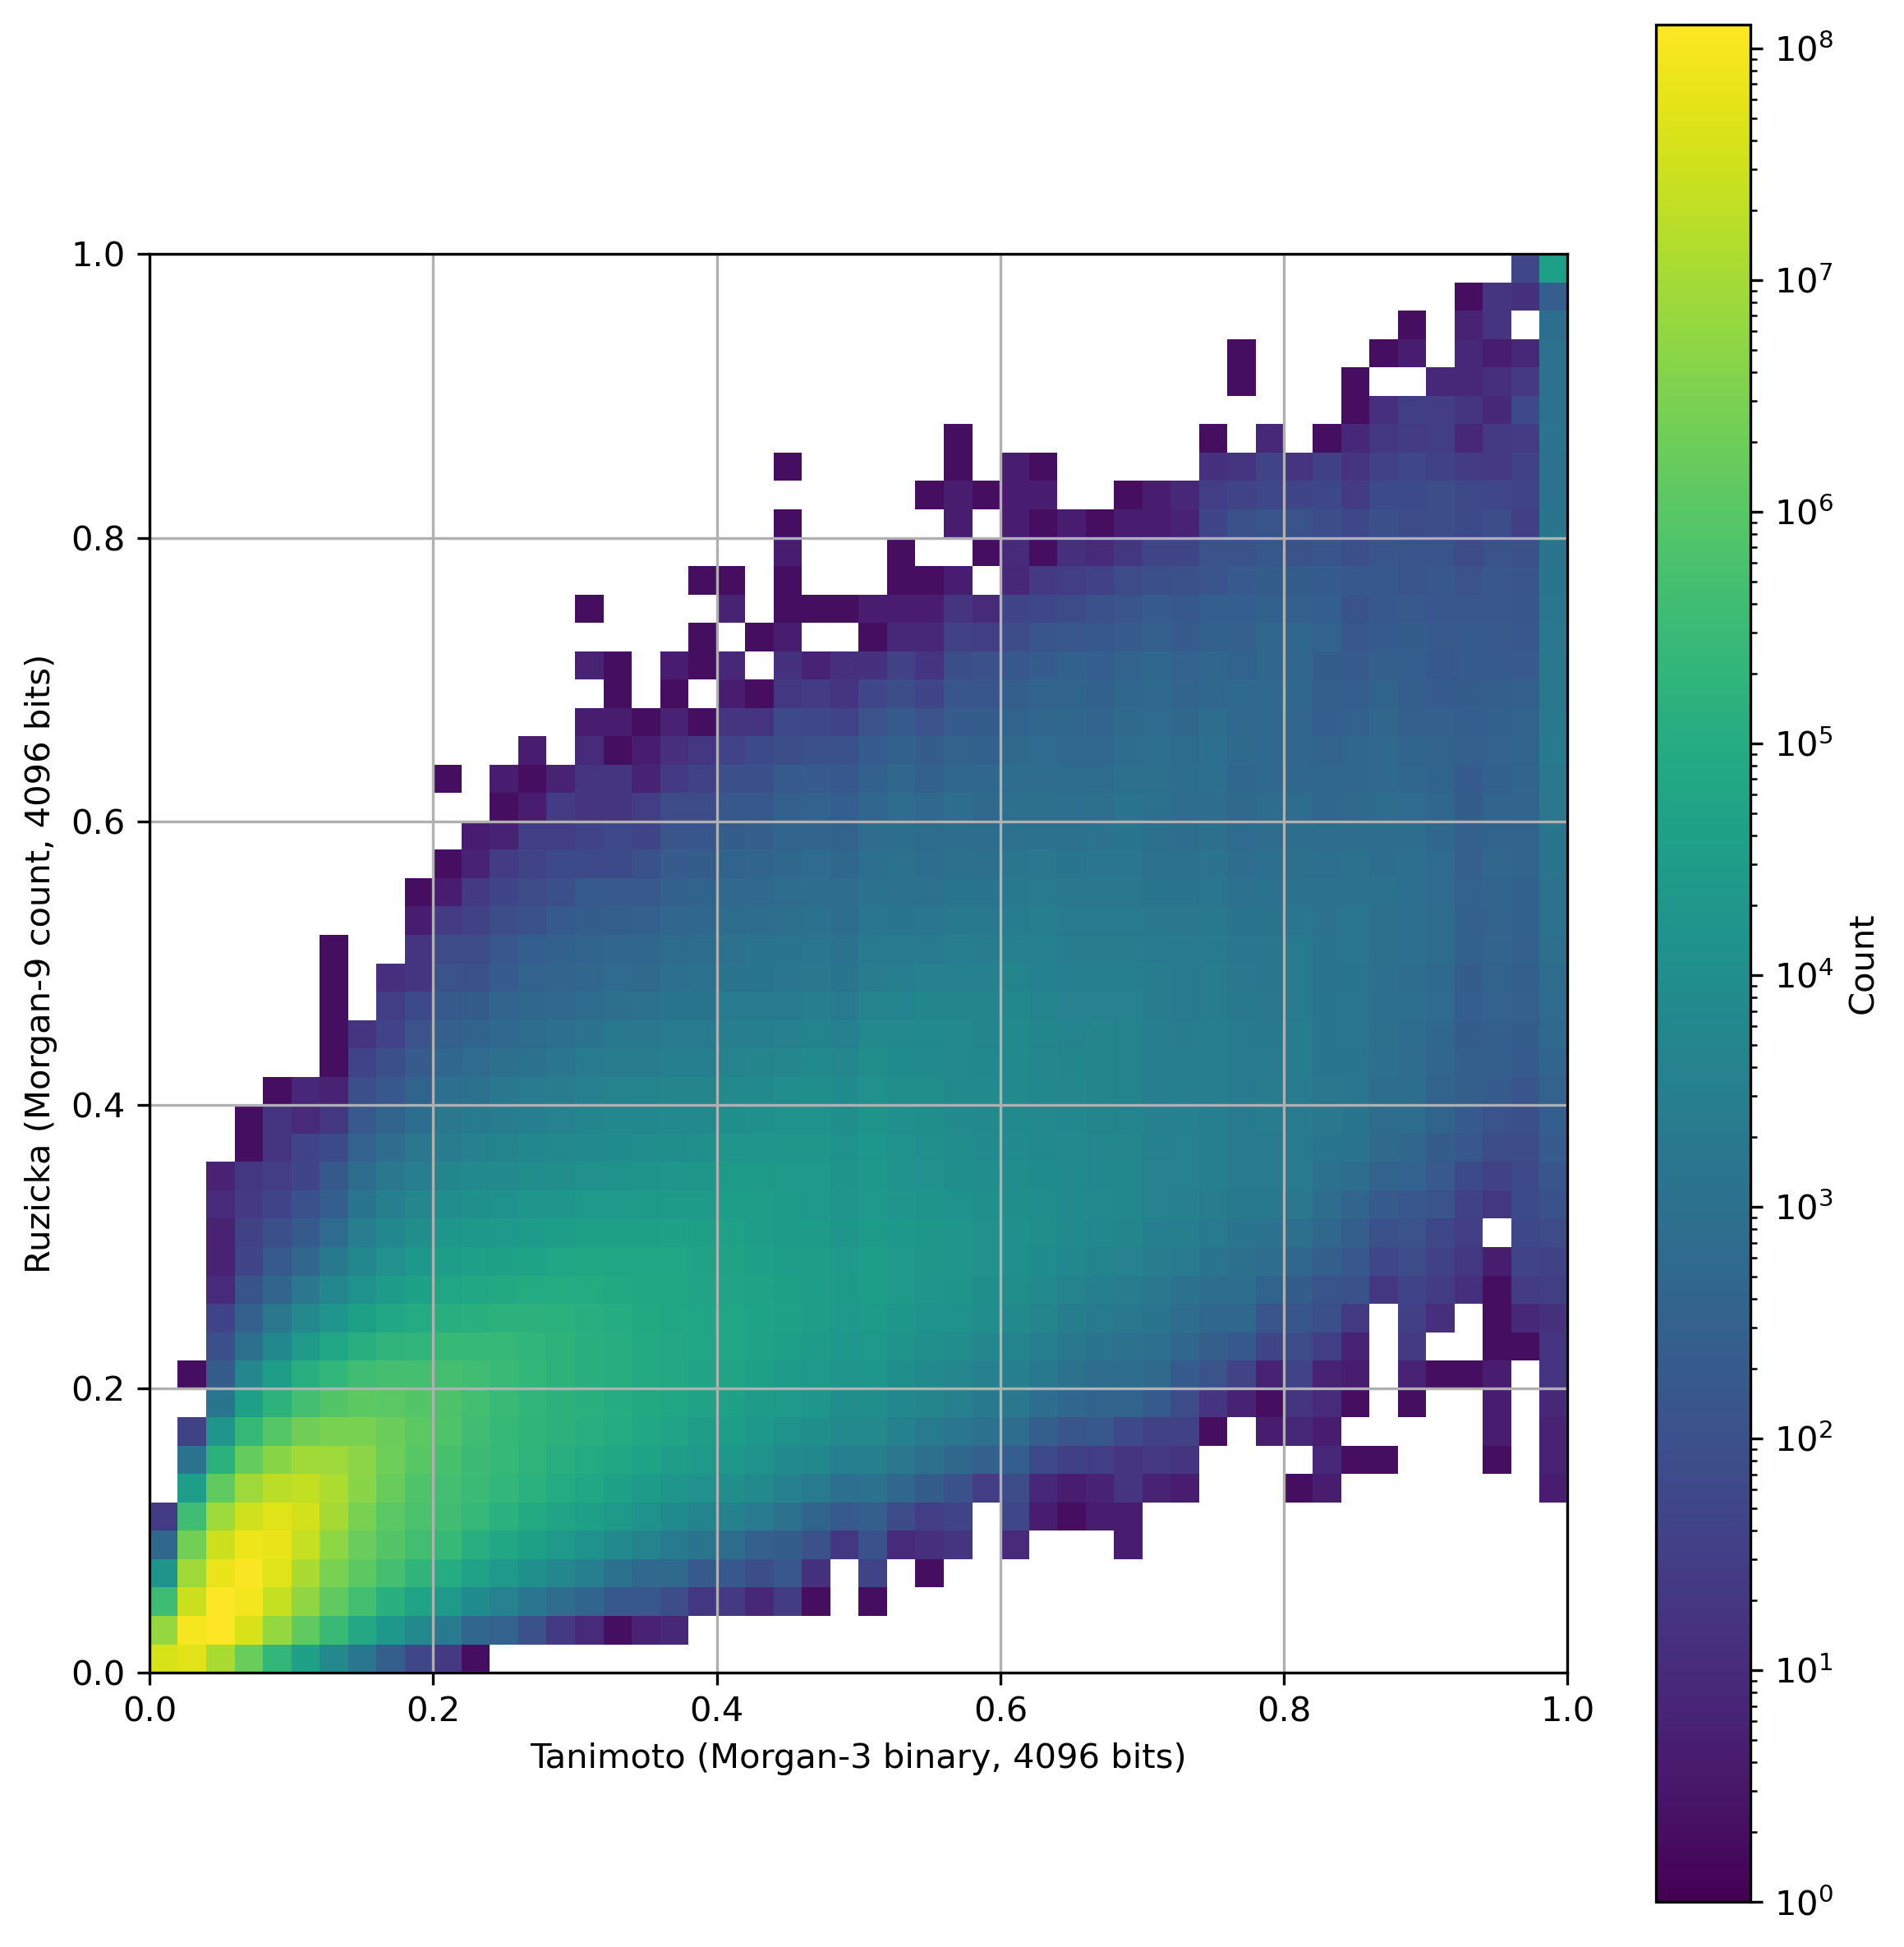

In [75]:
heatmap_comparison(
    similarities_morgan3,
    similarities_morgan9_count,
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    f"Ruzicka (Morgan-9 count, {NBITS} bits)",
    bins=50,
    filename="heatmap_tanimoto_morgan3_vs_ruzicka_morgan9.png"
)

## Compare to MAP4

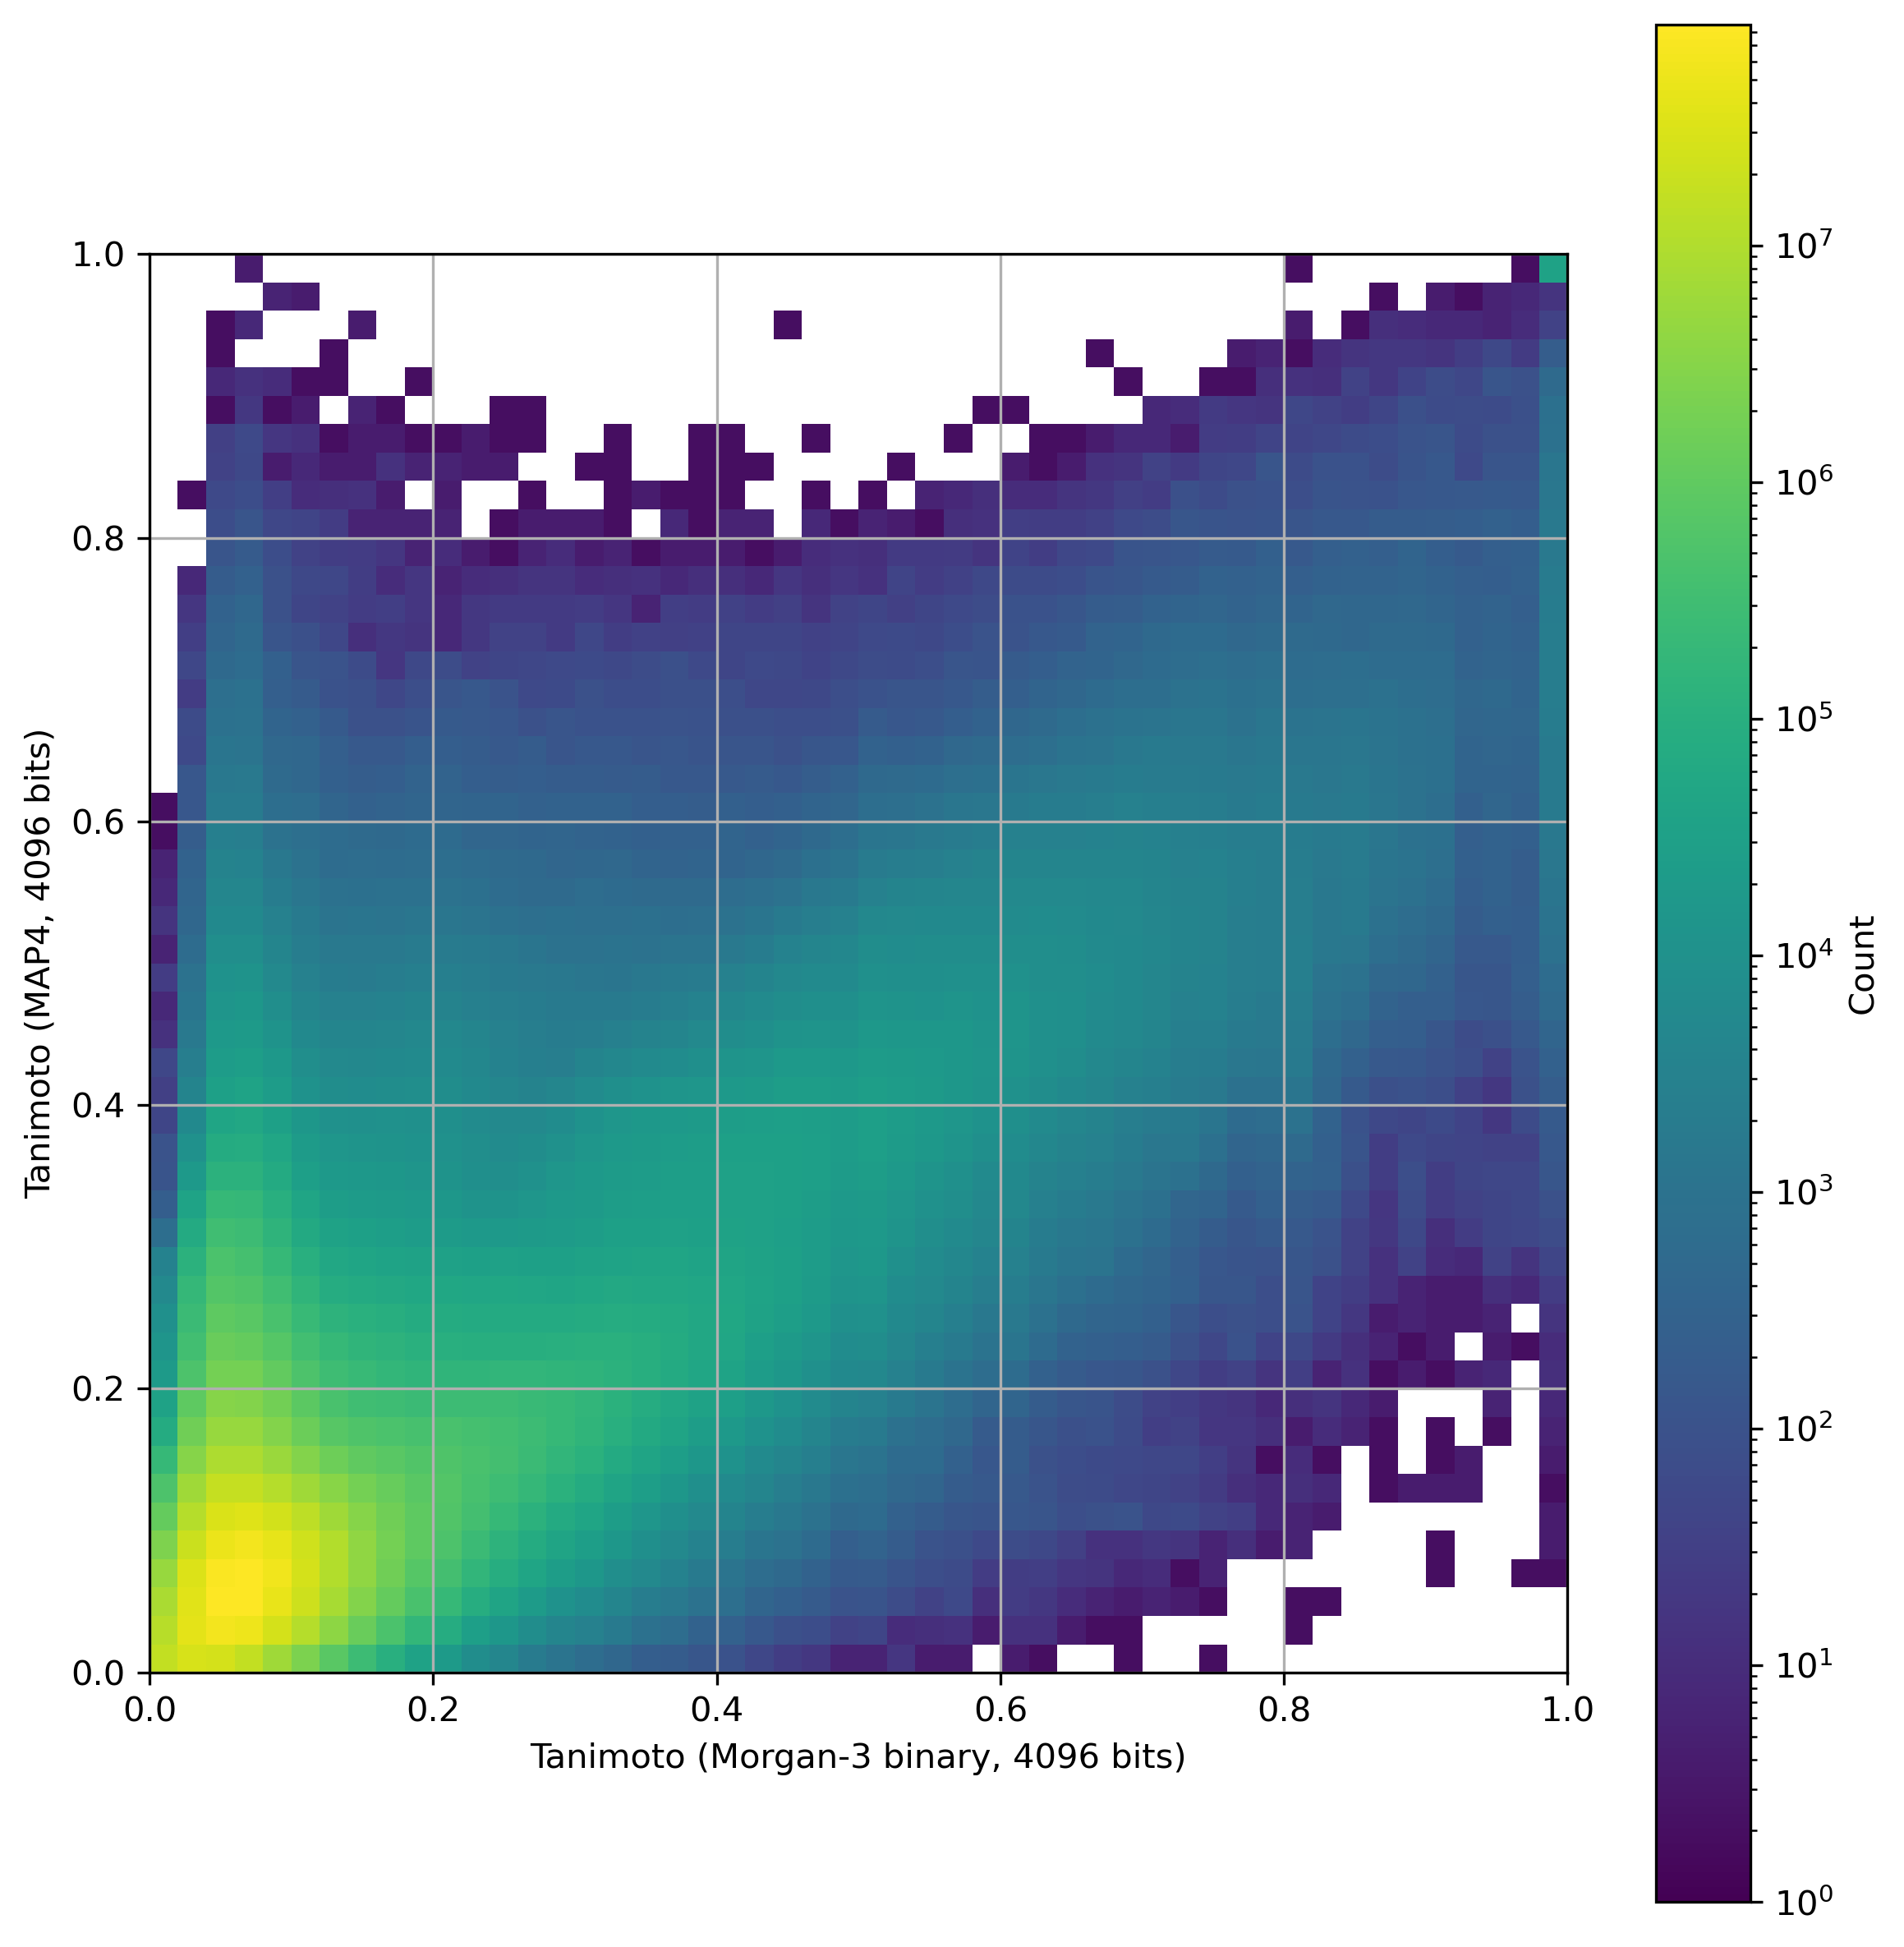

In [81]:
heatmap_comparison(
    similarities_morgan3,
    similarities_map4,
    f"Tanimoto (Morgan-3 binary, {NBITS} bits)",
    f"Tanimoto (MAP4, {NBITS} bits)",
    bins=50,
    filename="heatmap_tanimoto_morgan3_vs_tanimoto_map4.png"
)

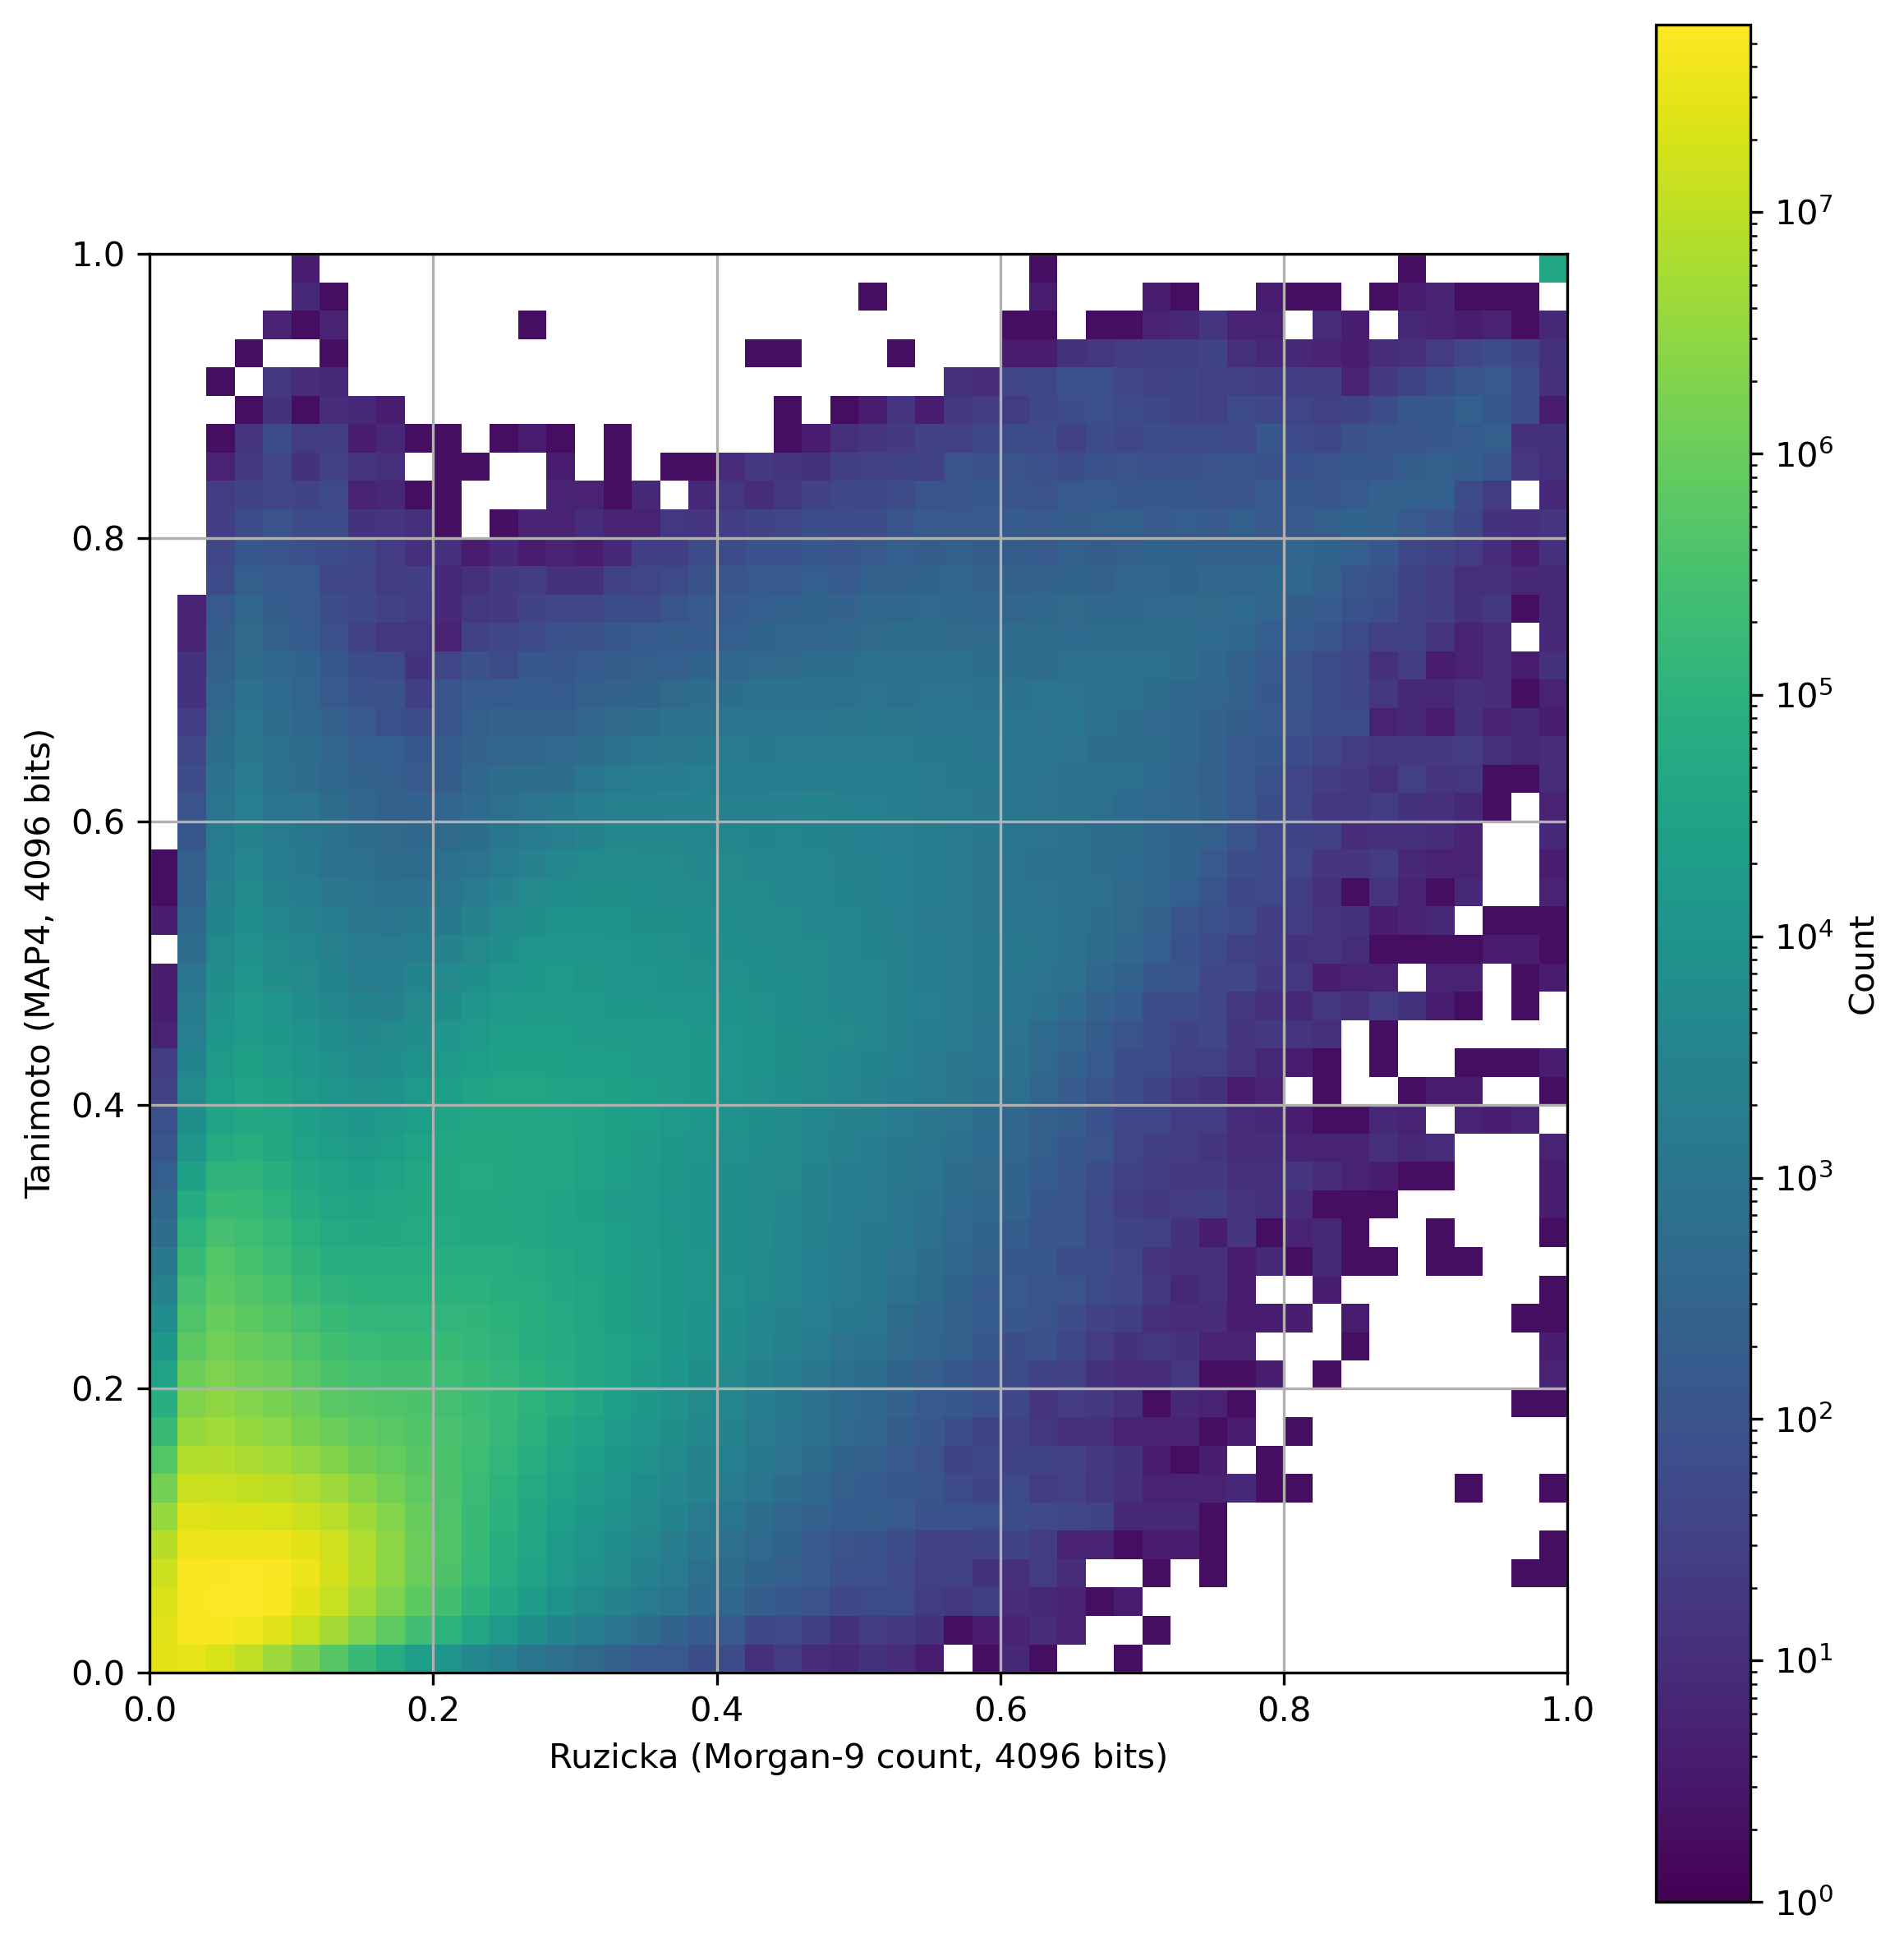

In [80]:
heatmap_comparison(
    similarities_morgan9_count,
    similarities_map4,
    f"Ruzicka (Morgan-9 count, {NBITS} bits)",
    f"Tanimoto (MAP4, {NBITS} bits)",
    bins=50,
    filename="heatmap_ruzicka_morgan9_vs_tanimoto_map4.png"
)

In [88]:
def get_score_summary(id1, id2):
    scores = {
        "Tanimoto (rdkit binary fp)": similarities_rdkit[id1, id2],
        "Tanimoto (Morgan-3 binary fp)": similarities_morgan3[id1, id2],
        "Tanimoto (MAP4 fp)": similarities_map4[id1, id2],
        "Ruzicka (Morgan-3 count fp)": similarities_morgan3_count[id1, id2],
        "Ruzicka (Morgan-9 count fp)": similarities_morgan9_count[id1, id2],
    }
    scores = pd.DataFrame.from_dict(scores, orient='index', columns=["Score"])
    return scores

In [45]:
def get_score_summary(id1, id2):
    scores = {
        "Tanimoto (rdkit binary fp)": similarities_rdkit[id1, id2],
        "Scaled Tanimoto (Morgan-3 binary fp)": scaled_similarities_morgan3[id1, id2],
        "Scaled Tanimoto (MAP4 fp)": scaled_similarities_map4[id1, id2],
        "Scaled Ruzicka (Morgan-3 count fp)": scaled_similarities_morgan3_count[id1, id2],
        "Scaled Ruzicka (Morgan-9 count fp)": scaled_similarities_morgan9_count[id1, id2],
    }
    scores = pd.DataFrame.from_dict(scores, orient='index', columns=["Score"])
    return scores

In [33]:
def show_pairs(unique_pairs):
    for pair in unique_pairs:
        display(get_score_summary(pair[0], pair[1]))
    
        smiles1 = compounds.smiles[pair[0]]
        smiles2 = compounds.smiles[pair[1]]
        mol = Chem.MolFromSmiles(smiles1)
        display(mol)
        mol = Chem.MolFromSmiles(smiles2)
        display(mol)

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw


def show_pairs_in_grid(unique_pairs, ncols=2, figsize=(30, 18), filename=None):
    nrows = -(-len(unique_pairs) // ncols)  # Ceiling division to get number of rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten to iterate easily

    for i, pair in enumerate(unique_pairs):
        id1, id2 = pair
        ax = axes[i]
        
        # Get SMILES and render molecules
        smiles1 = compounds.smiles[pair[0]]
        smiles2 = compounds.smiles[pair[1]]
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        img = Draw.MolsToGridImage([mol1, mol2], molsPerRow=2, subImgSize=(800, 800), returnPNG=False)
        
        ax.imshow(img)
        ax.axis('off')
        
        # Get and display score summary below the molecules
        scores = get_score_summary(id1, id2)
        ax.set_title(f"Pair {i + 1}")
        ax.text(0.5, 0, scores.to_string(header=False), 
                transform=ax.transAxes, ha='center', fontsize=10, family='monospace')
    
    # Hide any unused subplots if number of pairs is less than grid size
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


In [43]:
# MANUAL CURATION!
selected_pairs_high12_low345 = [(769, 13201), (40, 36045), (11277, 11759),
                                (629, 4118), (709, 25756),
                                (279, 17156), (161, 27494)
                               ]

selected_pairs_high1245_low3 = [(3746, 7282), (1787, 22304), (4509, 36134)]

selected_pairs_low123_high45 = [(1151, 37592), (1398, 16827)]

selected_pairs_low1245_high3 = [(206, 28321), (562, 24300), (24440, 37563), (1495, 4507), (1495, 10679), (12197, 30695)]

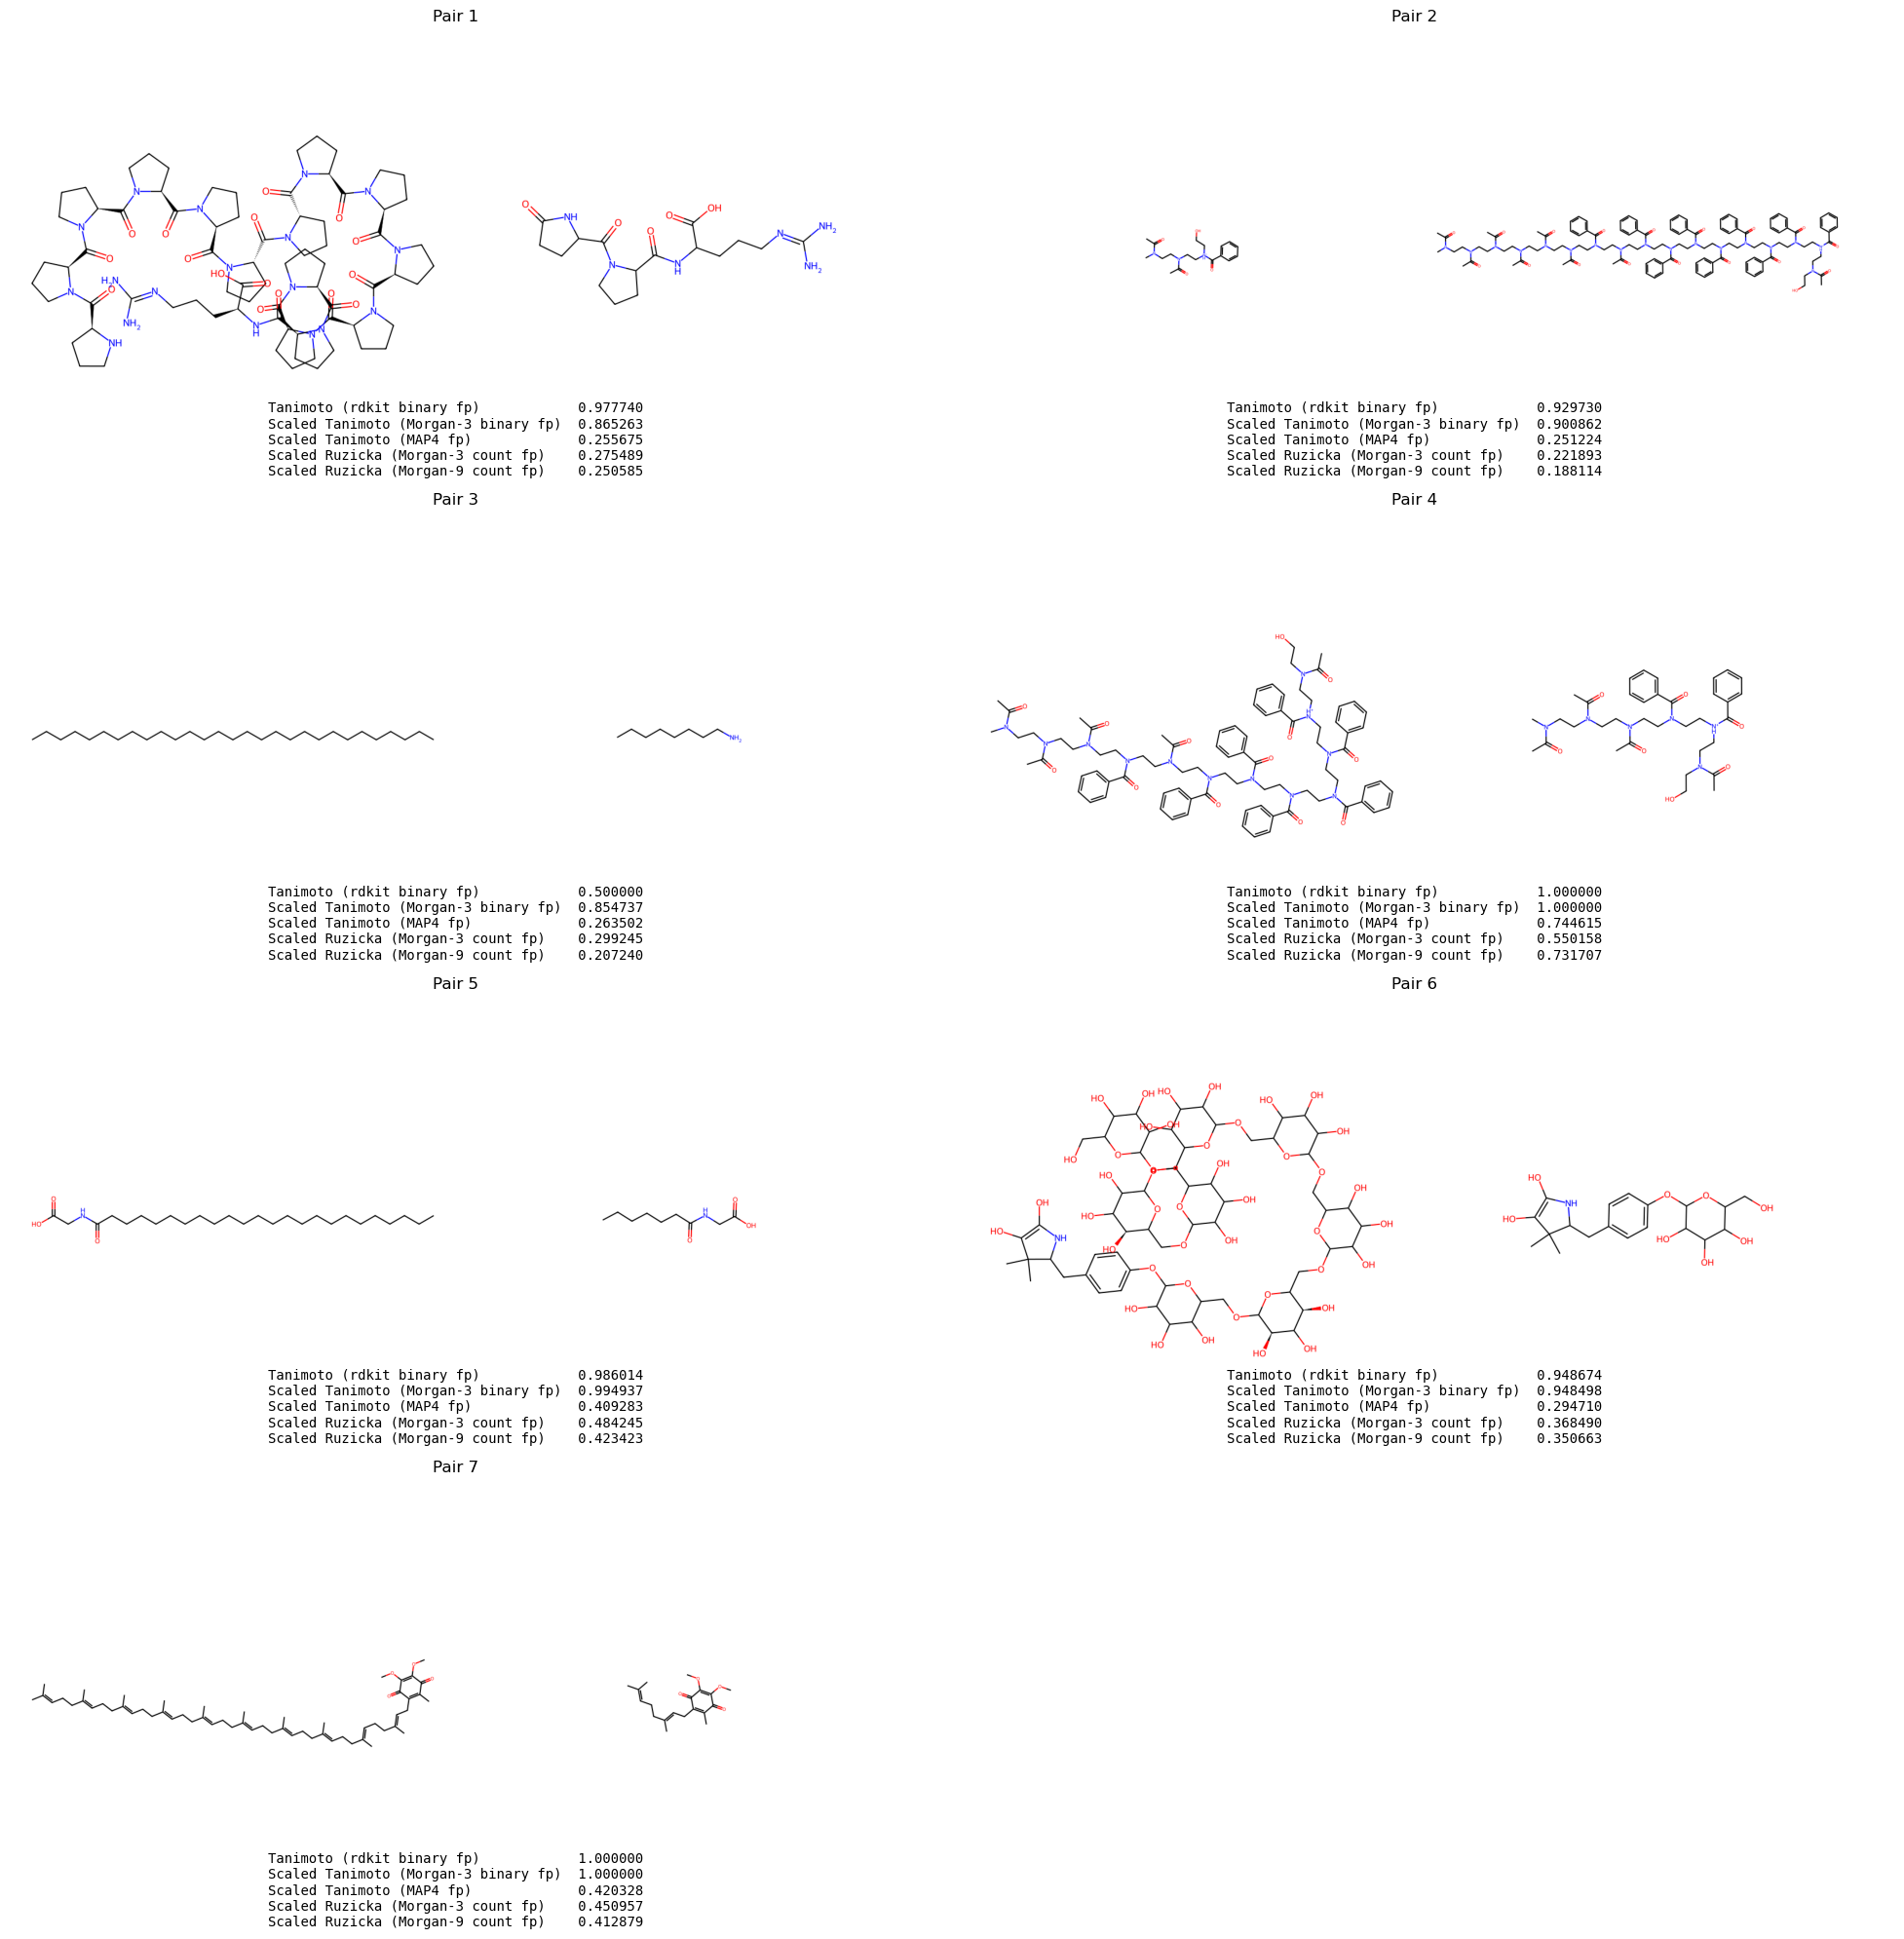

In [47]:
show_pairs_in_grid(selected_pairs_high12_low345, ncols=2, figsize=(20, 20),
                   filename="selected_pairs_high12_low345.png"
                  )

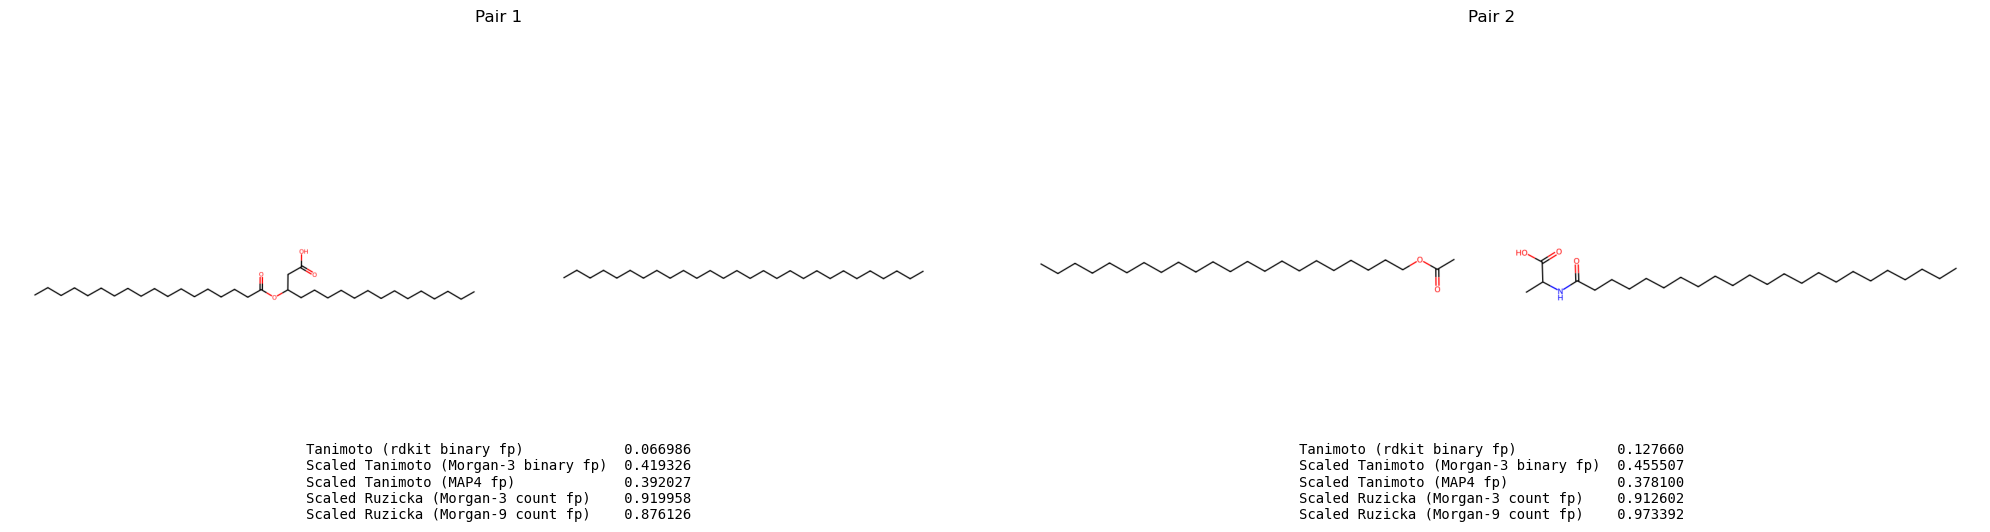

In [48]:
show_pairs_in_grid(selected_pairs_low123_high45 , ncols=2, figsize=(20, 20),
                   filename="selected_pairs_low123_high45.png"
                  )

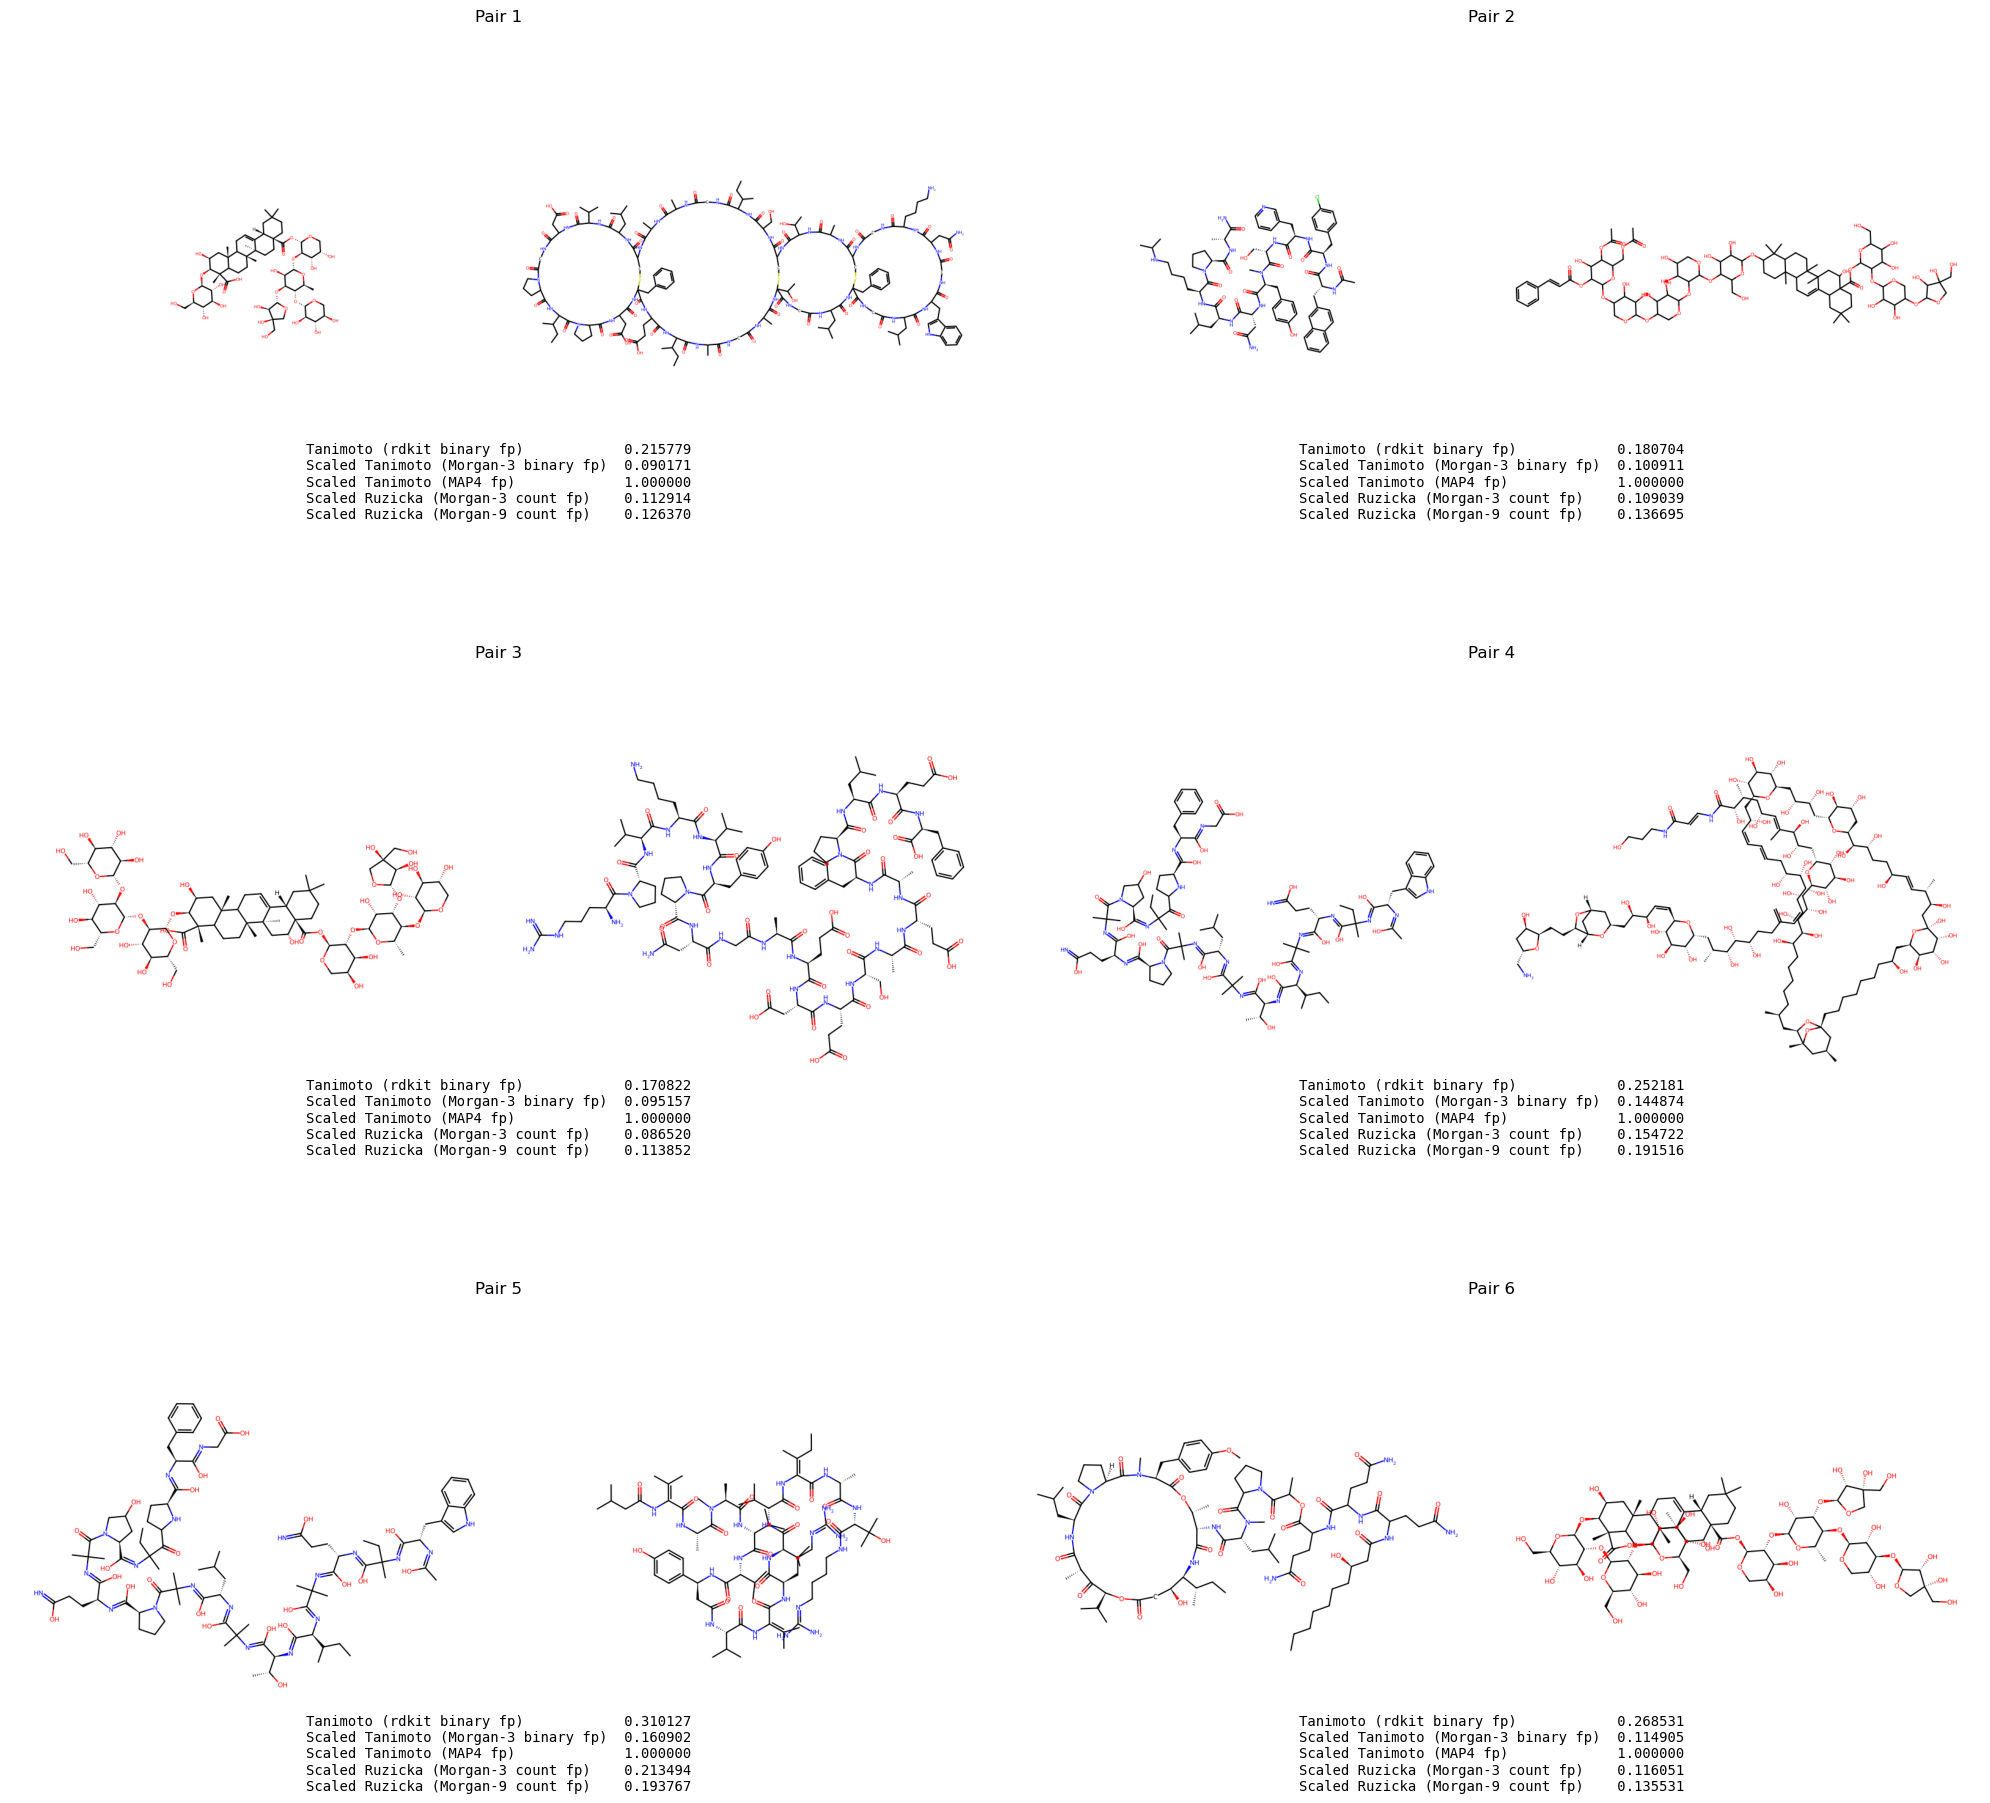

In [50]:
show_pairs_in_grid(selected_pairs_low1245_high3 , ncols=2, figsize=(20, 20),
                   filename="selected_pairs_low1245_high3.png"
                  )

In [38]:
idx = np.where((scaled_similarities_morgan3_count > 0.8) \
               & (scaled_similarities_morgan3 < 0.35) \
               #& (similarities_map4 > 0.5)
              )
idx[0].shape

(242,)

In [149]:
idx = np.where((similarities_morgan3_count > 0.9) \
               #& (similarities_morgan3 < 0.2) \
               & (similarities_map4 < 0.4)
              )
idx[0].shape

(240,)

In [145]:
# idx = np.where(np.abs(similarities_morgan3_count - similarities_morgan3) > 0.5) 
idx = np.where(((similarities_morgan3_count - similarities_morgan3) < -0.5) \
               & (similarities_map4 > 0.5)
              ) 
idx[0].shape

(18,)